# Investment Management with Python and Machine Learning

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import edhec_risk_kit as erk
from scipy.optimize import minimize

## Introduction to Portfolio Construction and Analysis with Python

### **Analyzing returns**

**Learning Objectives**

* Understand fundamentals of returns, multiple sets of returns using vectors
* Understand risk adjusted measures
* Understand non-Gaussian distribution, skewness and kurtosis
* Understand downside risk measures
* Estimate value at risk
* Implement the concepts using the lab sessions

#### **Section 1 - Fundamentals of risk and returns**

##### Fundamentals of returns

Average returns are not a good way to look at how an asset behaves

The return from time $t$ to time ${t+1}$ is given by:

$$ R_{t,t+1} = \frac{P_{t+1}-P_{t}}{P_{t}} $$

or alternately

$$ R_{t,t+1} = \frac{P_{t+1}}{P_{t}} - 1 $$

When dealing with stocks, if we want to compute the total return, we should add the money that we got as a dividend:

$$ R_{t,t+1} = \frac{P_{t+1}+D_{t,t+1}-P_{t}}{P_{t}} $$

**Multi period returns** 

<c>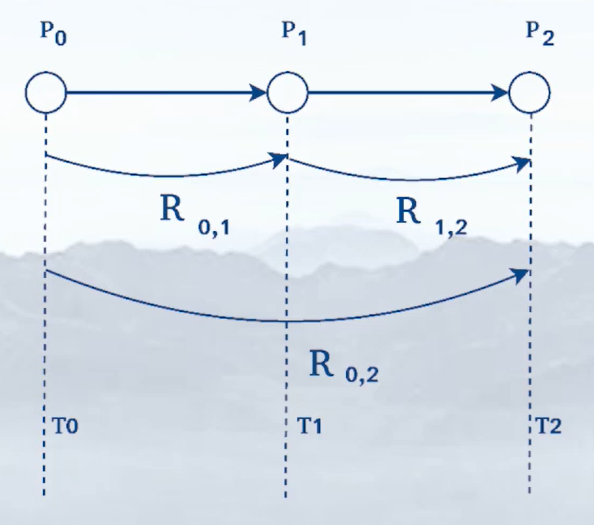</c>

$$R_{t, t+2} = (1+R_{t,t+1})(1+R_{t+1,t+2}) - 1 $$

**Example:** you buy a stock that returns 10% on the first day then returs -3% on the second day.

Compounded return will just be: 

$$ (1+0.10)(1-0.03)-1 $$ 



In [10]:
round((1+0.10)*(1-0.03)-1, 3)

0.067

**Anualizing returns:** This is a useful process to compare returns across different periods of time i.e., comparing a monthly return with quarterly or a daily return. The anualized return is nothing more than the return you'll get if the return that you're looking at had continued for a year. 

**Example:** the return over the month is 1%. What's the annualized return? 

$$ \cancel{12 * 1\% = 12\%}$$ 

$$ (1+0.01)^{12} - 1 = 12.68\% $$ 

In [11]:
# A stock gains 1% over a quarter (i.e. a 3 month period). What's the annualized return?

(1+0.01)**4 - 1 # The return is (1+0.01)^4-1, since there are 4 quarters in a year

0.040604010000000024

##### Lab Session - Basics of Returns

In this lab we'll work the very basics of Returns - computing returns, and compounding a sequence of returns.

Let's start with a set of prices for a stock "A", in a python list:

In [4]:
prices_a = [8.70, 8.91, 8.71]

In [5]:
prices_a[1:]

[8.91, 8.71]

In [6]:
prices_a[:-1]

[8.7, 8.91]

However, since Python lists do not operate as vectors, that will not work, generating an error about "/" not working for lists.

In [7]:
prices_a[1:]/prices_a[:-1] - 1

TypeError: unsupported operand type(s) for /: 'list' and 'list'

Instead, we can convert them to a `numpy` array. Numpy arrays _do_ behave like vectors, so this works:

In [8]:
prices_a = np.array(prices_a)

In [9]:
prices_a[1:]/prices_a[:-1] - 1

array([ 0.02413793, -0.02244669])

Now, let's add a few more days of prices and introduce a second stock. Let's call these two stocks "Blue" and "Orange". Instead of using raw numpy arrays, we are going to use the far more powerful Pandas DataFrame.

In [10]:
prices = pd.DataFrame({
    'Blue': [8.70, 8.91, 8.71, 8.43, 8.73],
    'Orange': [10.66, 11.08, 10.71, 11.59, 12.11]
})

In [11]:
prices

Blue  Orange
0  8.70   10.66
1  8.91   11.08
2  8.71   10.71
3  8.43   11.59
4  8.73   12.11

In [12]:
prices.iloc[1:]

Blue  Orange
1  8.91   11.08
2  8.71   10.71
3  8.43   11.59
4  8.73   12.11

In [13]:
prices.iloc[:-1]

Blue  Orange
0  8.70   10.66
1  8.91   11.08
2  8.71   10.71
3  8.43   11.59

**WARNING**

However, because Pandas DataFrames will align the row index (in this case: 0, 1, 2, 3, 4) the exact same code fragment will not work as you might expect.

In [14]:
prices.iloc[1:] / prices.iloc[:-1] - 1

Blue  Orange
0   NaN     NaN
1   0.0     0.0
2   0.0     0.0
3   0.0     0.0
4   NaN     NaN

We can instead use the method `.values` to convert the DataFrame and just pull the values out to a numpy array/matrix

In [15]:
prices.iloc[1:].values / prices.iloc[:-1] - 1

Blue    Orange
0  0.024138  0.039400
1 -0.022447 -0.033394
2 -0.032147  0.082166
3  0.035587  0.044866

Another way to do it: we can use the pandas method ``shift()``

In [16]:
prices / prices.shift(1) - 1

Blue    Orange
0       NaN       NaN
1  0.024138  0.039400
2 -0.022447 -0.033394
3 -0.032147  0.082166
4  0.035587  0.044866

Pandas has already a built-in method to do this, called ``pct_change()``

In [17]:
prices.pct_change()

Blue    Orange
0       NaN       NaN
1  0.024138  0.039400
2 -0.022447 -0.033394
3 -0.032147  0.082166
4  0.035587  0.044866

In [18]:
prices = pd.read_csv('data/sample_prices.csv')
prices

BLUE   ORANGE
0   8.7000  10.6600
1   8.9055  11.0828
2   8.7113  10.7100
3   8.4346  11.5907
4   8.7254  12.1070
5   9.0551  11.7876
6   8.9514  11.2078
7   9.2439  12.5192
8   9.1276  13.3624
9   9.3976  14.4080
10  9.4554  11.9837
11  9.5704  12.2718
12  9.7728  11.5892

In [19]:
returns = prices.pct_change()
returns

BLUE    ORANGE
0        NaN       NaN
1   0.023621  0.039662
2  -0.021807 -0.033638
3  -0.031763  0.082232
4   0.034477  0.044544
5   0.037786 -0.026381
6  -0.011452 -0.049187
7   0.032676  0.117008
8  -0.012581  0.067353
9   0.029581  0.078249
10  0.006151 -0.168261
11  0.012162  0.024041
12  0.021149 -0.055623

<AxesSubplot: >

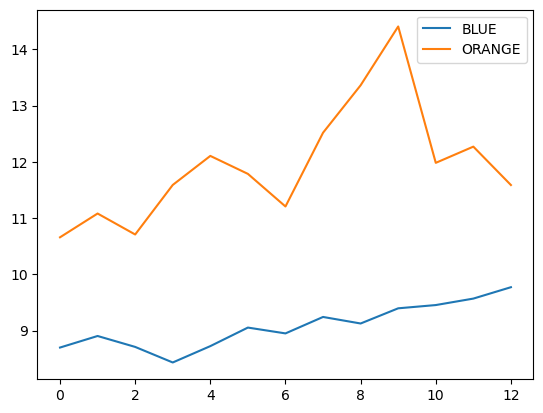

In [22]:
prices.plot()

<AxesSubplot: >

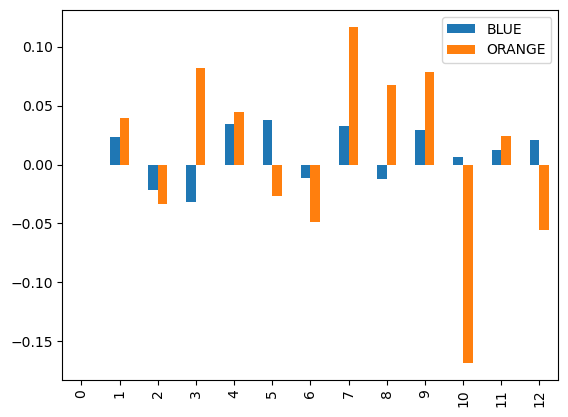

In [23]:
returns.plot.bar()

Computing the standard deviation of these assets

In [24]:
returns.std()

BLUE      0.023977
ORANGE    0.079601
dtype: float64

In [25]:
returns.mean()

BLUE      0.01
ORANGE    0.01
dtype: float64

In [26]:
np.prod(returns + 1) - 1

BLUE      0.123310
ORANGE    0.087167
dtype: float64

In [27]:
(returns + 1).prod() - 1

BLUE      0.123310
ORANGE    0.087167
dtype: float64

**Annualization**

In [32]:
rm = 0.01
(1 + rm) ** 12

1.1268250301319698

In [31]:
rq = 0.04
(1 + rq) ** 4

1.1698585600000002

In [33]:
rd = 0.0001
(1 + rd) ** 252

1.0255189119876946

##### Measures of risk and reward

We compute the **average of the square** of the deviations from the mean. This measure is called variance and is computed as follows:

$$\sigma_{R}^2 = \frac{1}{N} \sum_{i=1}^{N} {(R_i - \bar{R})^2}$$

Where $\bar{R}$ is the arithmetic mean of the returns. 

The variance of a set of returns is nothing more than the average of the square of the deviations from its mean.

The standard deviation is given by:

$$\sigma_{R} = \sqrt{\frac{1}{N} \sum_{i=1}^{N} {(R_i - \bar{R})^2}}$$

**Annualizing volatility**

We can't compare the volatility from daily data with the volatility from monthly data. For that we have to annualize volatility, and we do it the following way:

$$\sigma_{ann} = \sigma_{p}\sqrt{p}$$

There are approximately 252 trading days per calendar year

**Example** The standard deviation of a stock's daily return series is $0.1\%$

$$0.001 \cdot \sqrt{252} = 1.58\% $$

**Risk Adjusted Measures** 

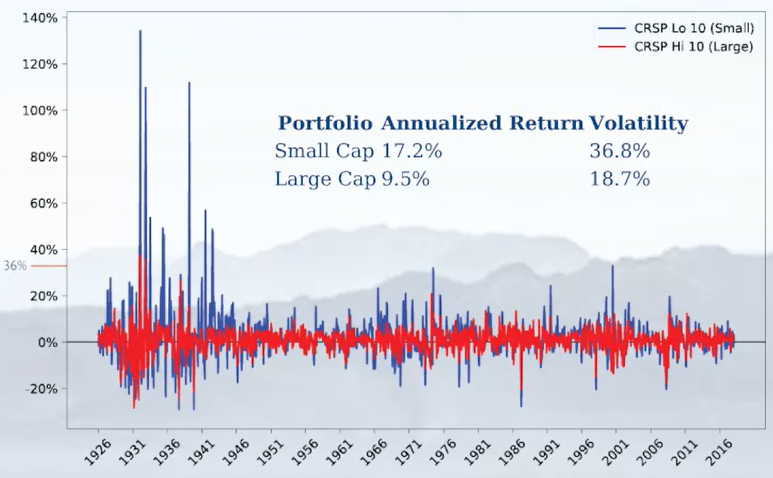

The blue line are US small caps, and the red line are US large caps. How do we compare these two? One way to think it about it is to simply compute the ratio, how much return did I get per unit risk?

That's called the return on risk ratio. 

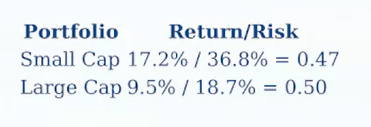

We should look at its excess return over the risk free rate

$$ Return\: on\: Risk\: Ratio = \frac{Return}{Volatility}$$

$$ Sharpe\: Ratio = \frac{Return\: minus\: risk\: free\: rate}{Volatility}$$

$$ Sharpe\: Ratio(P) = \frac{R_p-R_f}{\sigma_p}$$

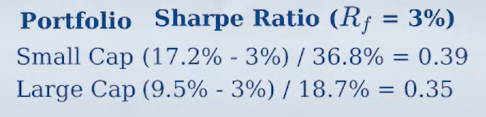

##### Lab Session - Risk Adjusted Returns

We've seen that the volatility is measured by the average squared deviation from the mean, which is the standard deviation.

Let's read the sample returns that we've been working with.

In [39]:
prices = pd.read_csv('data/sample_prices.csv')

returns = prices.pct_change()
returns

BLUE    ORANGE
0        NaN       NaN
1   0.023621  0.039662
2  -0.021807 -0.033638
3  -0.031763  0.082232
4   0.034477  0.044544
5   0.037786 -0.026381
6  -0.011452 -0.049187
7   0.032676  0.117008
8  -0.012581  0.067353
9   0.029581  0.078249
10  0.006151 -0.168261
11  0.012162  0.024041
12  0.021149 -0.055623

Notice that the first set of returns are NaN, which is Pandas way of saying that it's an NA. We can drop that row using the `.dropna()` method.

In [40]:
returns = returns.dropna()
returns

BLUE    ORANGE
1   0.023621  0.039662
2  -0.021807 -0.033638
3  -0.031763  0.082232
4   0.034477  0.044544
5   0.037786 -0.026381
6  -0.011452 -0.049187
7   0.032676  0.117008
8  -0.012581  0.067353
9   0.029581  0.078249
10  0.006151 -0.168261
11  0.012162  0.024041
12  0.021149 -0.055623

Let's compute the standard deviation from first principals:

In [45]:
returns.shape[0]

12

In [48]:
devations = returns - returns.mean()
squared_deviations = devations ** 2
variance = squared_deviations.sum()/(returns.shape[0]-1)
volatility = np.sqrt(variance)
volatility

BLUE      0.023977
ORANGE    0.079601
dtype: float64

We annualize volatility by scaling (multiplying) it by the square root of the number of periods per observation

Therefore, to annualize the volatility of a monthly series, we muiltiply it by the square root of 12. Instead of using the `np.sqrt()` we can raise it to the power of $0.5$

In [49]:
# Annualizing it

volatility * np.sqrt(12)

BLUE      0.083060
ORANGE    0.275747
dtype: float64

Let's get beyond the sample data series and start working with some real data. Read in the monthly returns of a set of 10 portfolios formed on market caps, or market equities of the companies. Of the 10 portfolios, we only want to look at the largest cap and the smallest cap companies:

In [52]:
returns = pd.read_csv('data/Portfolios_Formed_on_ME_monthly_EW.csv', 
            header = 0, index_col = 0, parse_dates = True, na_values = -99.99)

In [54]:
returns.head()

<= 0  Lo 30  Med 40  Hi 30  Lo 20  Qnt 2  Qnt 3  Qnt 4  Hi 20  Lo 10  \
192607   NaN  -0.43    1.52   2.68  -0.57   0.59   1.60   1.47   3.33  -1.45   
192608   NaN   3.90    3.04   2.09   3.84   3.59   3.71   1.61   2.33   5.12   
192609   NaN  -1.08   -0.54   0.16  -0.48  -1.40   0.00  -0.50  -0.09   0.93   
192610   NaN  -3.32   -3.52  -3.06  -3.29  -4.10  -2.89  -3.36  -2.95  -4.84   
192611   NaN  -0.46    3.82   3.09  -0.55   2.18   3.41   3.39   3.16  -0.78   

        Dec 2  Dec 3  Dec 4  Dec 5  Dec 6  Dec 7  Dec 8  Dec 9  Hi 10  
192607   0.29  -0.15   1.33   1.24   1.98   1.55   1.38   3.38   3.29  
192608   2.59   4.03   3.15   2.72   4.72   1.60   1.63   0.98   3.70  
192609  -1.87  -2.27  -0.53   0.07  -0.07  -1.64   0.64  -0.86   0.67  
192610  -1.77  -3.36  -4.83  -2.98  -2.80  -3.45  -3.27  -3.47  -2.43  
192611  -0.32  -0.29   4.65   3.24   3.57   3.82   2.95   3.61   2.70

In [59]:
columns = ['Lo 10', 'Hi 10']

returns = returns[columns]
returns.head()

Lo 10  Hi 10
192607  -1.45   3.29
192608   5.12   3.70
192609   0.93   0.67
192610  -4.84  -2.43
192611  -0.78   2.70

Note that the data is already given in percentages (i.e 4.5 instead of 0.045) and we typically want to use the actual numbers (i.e. 0.045 instead of 4.5) so we should divide the raw data from the file by 100.

In [60]:
returns = returns / 100
returns.head()

Lo 10   Hi 10
192607 -0.0145  0.0329
192608  0.0512  0.0370
192609  0.0093  0.0067
192610 -0.0484 -0.0243
192611 -0.0078  0.0270

In [61]:
returns.columns = ['SmallCap', 'LargeCap']
returns.head()

SmallCap  LargeCap
192607   -0.0145    0.0329
192608    0.0512    0.0370
192609    0.0093    0.0067
192610   -0.0484   -0.0243
192611   -0.0078    0.0270

<AxesSubplot: >

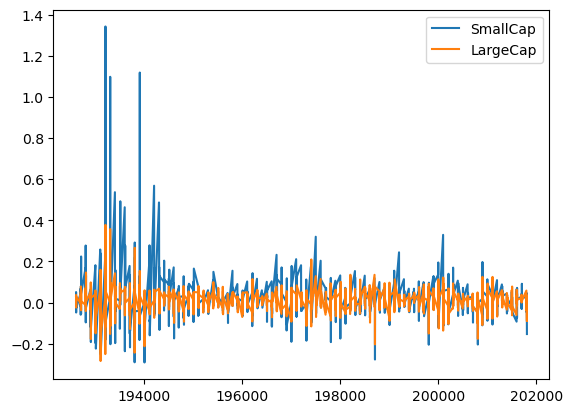

In [62]:
returns.plot.line()

In [63]:
returns.std()

SmallCap    0.106288
LargeCap    0.053900
dtype: float64

In [65]:
annualized_vol = returns.std() * np.sqrt(12)
annualized_vol

SmallCap    0.368193
LargeCap    0.186716
dtype: float64

We can now compute the annualized returns as follows:

In [66]:
n_months = returns.shape[0]
return_per_month = (returns + 1).prod() ** (1/n_months) - 1
return_per_month

SmallCap    0.012986
LargeCap    0.007423
dtype: float64

In [67]:
annualized_return = (return_per_month + 1) ** 12 - 1
annualized_return

SmallCap    0.167463
LargeCap    0.092810
dtype: float64

In [69]:
# Another way to compute the annualized return 
annualized_return = (returns + 1).prod() ** (12/n_months) - 1
annualized_return

SmallCap    0.167463
LargeCap    0.092810
dtype: float64

In [70]:
annualized_return / annualized_vol

SmallCap    0.454825
LargeCap    0.497063
dtype: float64

In [71]:
riskfree_rate = 0.03

excess_return = annualized_return - riskfree_rate

sharpe_ratio = excess_return / annualized_vol
sharpe_ratio

SmallCap    0.373346
LargeCap    0.336392
dtype: float64

**Exercise computing the sharpe ratio taking the smallest 20% vs the largest 20%**

In [73]:
returns = pd.read_csv('data/Portfolios_Formed_on_ME_monthly_EW.csv', 
            header = 0, index_col = 0, parse_dates = True, na_values = -99.99)

In [76]:
cols = ['Lo 20', 'Hi 20']
returns = returns[cols]
returns.head()

Lo 20  Hi 20
192607  -0.57   3.33
192608   3.84   2.33
192609  -0.48  -0.09
192610  -3.29  -2.95
192611  -0.55   3.16

In [77]:
returns = returns / 100 
returns.head()

Lo 20   Hi 20
192607 -0.0057  0.0333
192608  0.0384  0.0233
192609 -0.0048 -0.0009
192610 -0.0329 -0.0295
192611 -0.0055  0.0316

In [78]:
returns.std()

Lo 20    0.097197
Hi 20    0.056325
dtype: float64

In [80]:
returns.columns = ['SmallCap20', 'LargeCap20']
returns

SmallCap20  LargeCap20
192607     -0.0057      0.0333
192608      0.0384      0.0233
192609     -0.0048     -0.0009
192610     -0.0329     -0.0295
192611     -0.0055      0.0316
...            ...         ...
201808      0.0309      0.0249
201809     -0.0204      0.0019
201810     -0.1052     -0.0741
201811     -0.0278      0.0249
201812     -0.1477     -0.0921

[1110 rows x 2 columns]

<AxesSubplot: >

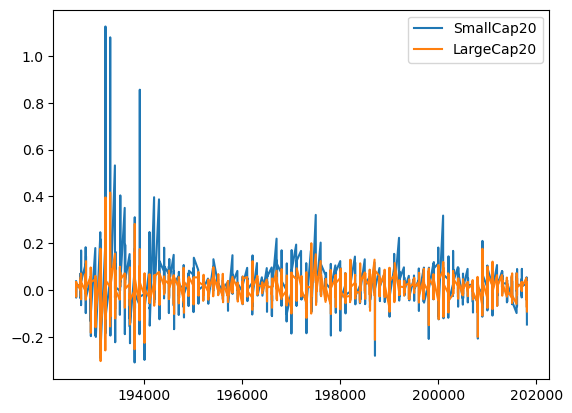

In [82]:
returns.plot.line()

In [84]:
annualized_vol = returns.std() * np.sqrt(12)
annualized_vol

SmallCap20    0.336701
LargeCap20    0.195116
dtype: float64

In [85]:
n_months = returns.shape[0]
annualized_return = (returns + 1).prod() ** (12/n_months) - 1
annualized_return

SmallCap20    0.151977
LargeCap20    0.098490
dtype: float64

In [86]:
annualized_return / annualized_vol

SmallCap20    0.451370
LargeCap20    0.504778
dtype: float64

In [87]:
riskfree_rate = 0.03

excess_return = annualized_return - riskfree_rate
sharpe_ratio = excess_return / annualized_vol
sharpe_ratio

SmallCap20    0.362271
LargeCap20    0.351023
dtype: float64

##### Measuring max drawdown

The max drawdown is the maximum loss from the previous high to a subsequent low. Buy at its highest value - sold at the bottom. The worst possible return you could have seen if you "buy high, sold low"

**Constructing a wealth index** 

1. Computing drawdowns is to construct a wealth index hypothetical buy-and-hold investment in the asset.

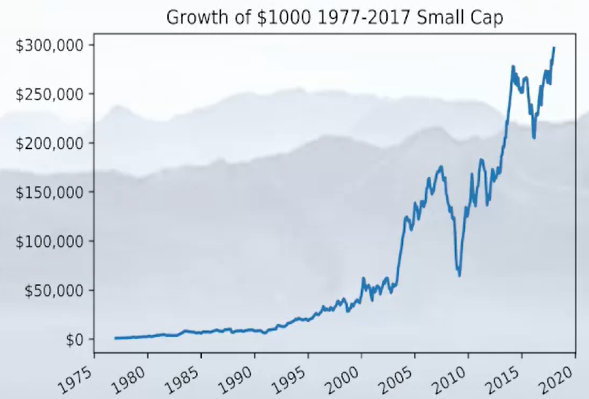

2. Look at the prior peak at any point in time

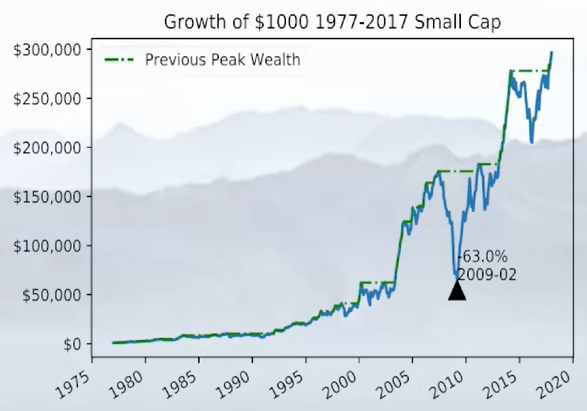

The drawdown is the distance from the green line to the blue line at any given point in time

* Drawdowns are entirely defined by two points and hence are very sensitive to outliers.
* They depend on the frequency of observations, in general, a very deep drawdown on a daily or weekly basis might almost completely dissapear or move to very different location based on monthly data.
* In spite of this shortcomings, drawdowns are closely monitored and popular amongst practicioners even though other measures like VAR and CVAR are more robust measures of extreme risk,

##### Lab Session - Drawdown

In this lab, we'll develop the code to compute the maximum drawdown of a return series, and we'll start to develop our own module which will act as a toolkit that we will add to during the course.

First, let's read the return series we processed in the previous lab:

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10752\3308855969.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  me_m = pd.read_csv('data/Portfolios_Formed_on_ME_monthly_EW.csv',


<Axes: >

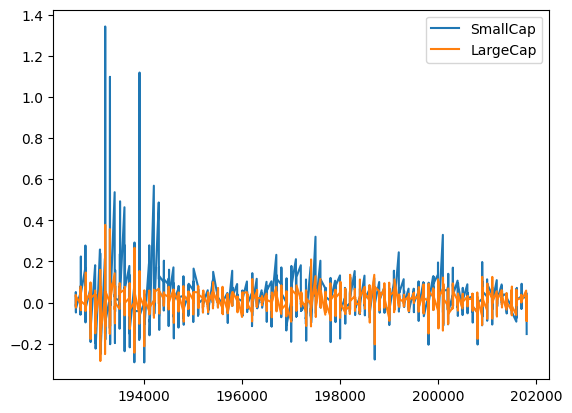

In [20]:
me_m = pd.read_csv('data/Portfolios_Formed_on_ME_monthly_EW.csv', 
            header = 0, index_col = 0, parse_dates = True, na_values = -99.99)

columns = ['Lo 10', 'Hi 10']
rets = me_m[columns]
rets.columns = ['SmallCap', 'LargeCap']
rets = rets / 100

rets.plot.line()

In [21]:
rets.head()

SmallCap  LargeCap
192607   -0.0145    0.0329
192608    0.0512    0.0370
192609    0.0093    0.0067
192610   -0.0484   -0.0243
192611   -0.0078    0.0270

Timeseries - forcing the index to be a datetime

In [22]:
# Checking if the index is in datetime format

rets.index

Index([192607, 192608, 192609, 192610, 192611, 192612, 192701, 192702, 192703,
       192704,
       ...
       201803, 201804, 201805, 201806, 201807, 201808, 201809, 201810, 201811,
       201812],
      dtype='int64', length=1110)

In [23]:
rets.index = pd.to_datetime(rets.index, format = '%Y%m')
rets.head()

SmallCap  LargeCap
1926-07-01   -0.0145    0.0329
1926-08-01    0.0512    0.0370
1926-09-01    0.0093    0.0067
1926-10-01   -0.0484   -0.0243
1926-11-01   -0.0078    0.0270

In [24]:
# Converting the timestamp to a monthly timestamp

rets.index = rets.index.to_period('M')
rets.head()

SmallCap  LargeCap
1926-07   -0.0145    0.0329
1926-08    0.0512    0.0370
1926-09    0.0093    0.0067
1926-10   -0.0484   -0.0243
1926-11   -0.0078    0.0270

**Compute Drawdowns**

1. Compute a wealth index
2. Compute previous peaks
3. Compute drawdown - which is the wealth value as a percentage of the previous peak

In [29]:
wealth_index = 1000 * (1 + rets['LargeCap']).cumprod()
wealth_index.head()

1926-07    1032.900000
1926-08    1071.117300
1926-09    1078.293786
1926-10    1052.091247
1926-11    1080.497711
Freq: M, Name: LargeCap, dtype: float64

<Axes: >

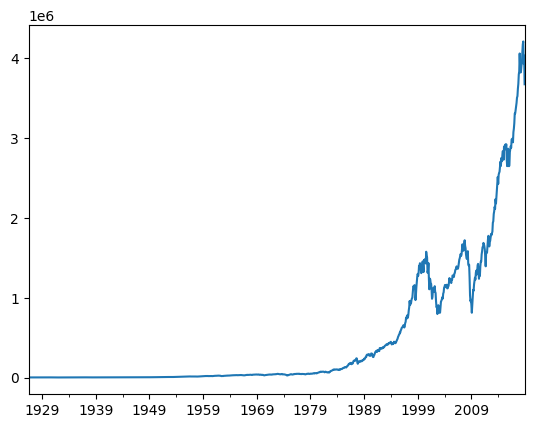

In [30]:
wealth_index.plot.line()

<Axes: >

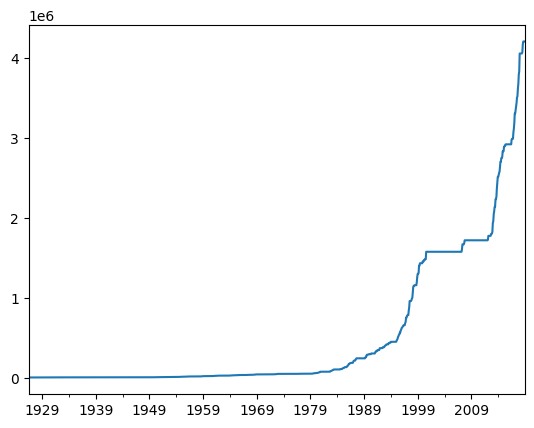

In [34]:
previous_peaks = wealth_index.cummax()
previous_peaks.plot()

<Axes: >

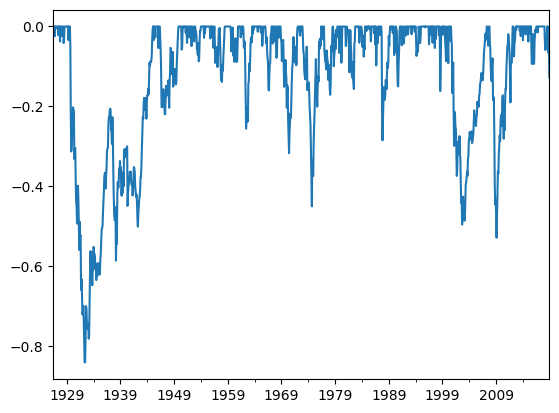

In [35]:
drawdown = (wealth_index - previous_peaks) / previous_peaks
drawdown.plot()

In the crash of 1929, people lost more than 80% of their wealth. Let's see that deeply

<Axes: >

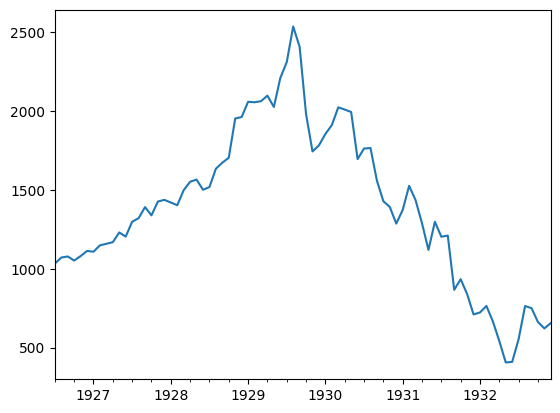

In [36]:
wealth_index['1926':'1932'].plot()

In [37]:
drawdown.min()

-0.8400375277943123

In [38]:
# Computing the maximum drawdown since 1975

drawdown['1975':].min()

-0.5280945042309304

In [39]:
# If we want to locate when that min happened, we use:

drawdown['1975':].idxmin()

Period('2009-02', 'M')

In [40]:
drawdown.idxmin()

Period('1932-05', 'M')

**Creating a Drawdown Function**

Redoing this analysis for SmallCap would be tedious, since we would need to re-enter all these commands at the prompt. Instead, let's create our first function that will form the first tool in our financial toolkit.

The function will take as input, a timeseries of returns, and return a timeseries as a DataFrame that contains the wealth index, the previous peaks and the drawdowns as a percent.

In [41]:
def drawdown(return_series: pd.Series) -> pd.DataFrame :
    '''
    Takes a time series of asset returns
    Computes and returns a DataFrame that contains:
    the wealth index
    the previous peaks
    percent drawdowns 
    '''

    wealth_index = 1000 * (1 + return_series).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks) / previous_peaks 

    return pd.DataFrame({
        'Wealth' : wealth_index,
        'Peaks' : previous_peaks,
        'Drawdown' : drawdowns
    })


In [42]:
drawdown(rets['LargeCap']).head()

Wealth        Peaks  Drawdown
1926-07  1032.900000  1032.900000    0.0000
1926-08  1071.117300  1071.117300    0.0000
1926-09  1078.293786  1078.293786    0.0000
1926-10  1052.091247  1078.293786   -0.0243
1926-11  1080.497711  1080.497711    0.0000

In [43]:
drawdown(rets['LargeCap'])[['Wealth', 'Peaks']].head()

Wealth        Peaks
1926-07  1032.900000  1032.900000
1926-08  1071.117300  1071.117300
1926-09  1078.293786  1078.293786
1926-10  1052.091247  1078.293786
1926-11  1080.497711  1080.497711

<Axes: >

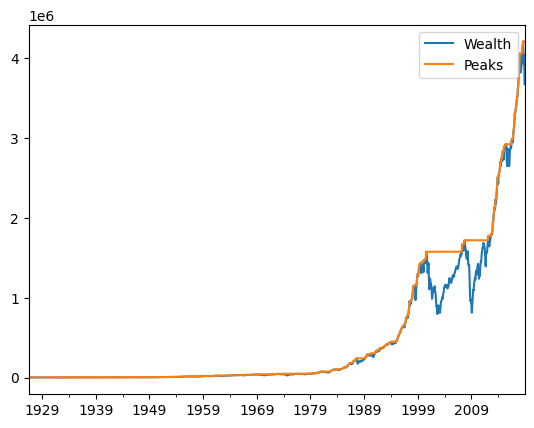

In [44]:
drawdown(rets['LargeCap'])[['Wealth', 'Peaks']].plot()

<Axes: >

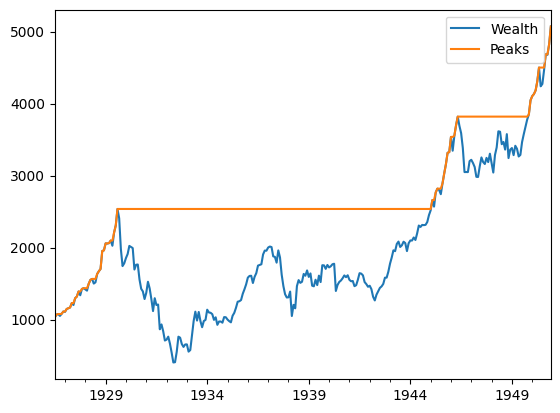

In [45]:
drawdown(rets[:'1950']['LargeCap'])[['Wealth', 'Peaks']].plot()

In [46]:
drawdown(rets['LargeCap'])['Drawdown'].min()

-0.8400375277943123

In [47]:
drawdown(rets['LargeCap'])['Drawdown'].idxmin()

Period('1932-05', 'M')

In [48]:
drawdown(rets['SmallCap'])['Drawdown'].min()

-0.8330007793945303

In [49]:
drawdown(rets['SmallCap'])['Drawdown'].idxmin()

Period('1932-05', 'M')

In [50]:
drawdown(rets['1975':]['LargeCap'])['Drawdown'].min()

-0.5280945042309303

In [51]:
drawdown(rets['1975':]['LargeCap'])['Drawdown'].idxmin()

Period('2009-02', 'M')

In [52]:
drawdown(rets['1975':]['SmallCap'])['Drawdown'].min()

-0.6312068077252386

In [53]:
drawdown(rets['1975':]['SmallCap'])['Drawdown'].idxmin()

Period('2009-02', 'M')

#### **Section 2 - Beyond the Gaussian case: Extreme risk estimates**

##### Deviations from Normality

Actual time series returns on different asset classes are actually not normally. The normal distribution assumption is kind of a simplifyng assumption that under estimate the magnitude of extreme returns 

**Mesokurtic (kurtosis = 3.0)**

The first category of kurtosis is mesokurtic distribution. This distribution has a kurtosis similar to that of the normal distribution, meaning the extreme value characteristic of the distribution is similar to that of a normal distribution. Therefore, a stock with a mesokurtic distribution generally depicts a moderate level of risk.

**Leptokurtic (kurtosis > 3.0)**

The second category is leptokurtic distribution. Any distribution that is leptokurtic displays greater kurtosis than a mesokurtic distribution. This distribution appears as a curve one with long tails (outliers.) The "skinniness" of a leptokurtic distribution is a consequence of the outliers, which stretch the horizontal axis of the histogram graph, making the bulk of the data appear in a narrow ("skinny") vertical range.

A stock with a leptokurtic distribution generally depicts a high level of risk but the possibility of higher returns because the stock has typically demonstrated large price movements.

**Platykurtic (kurtosis < 3.0)**

The final type of distribution is platykurtic distribution. These types of distributions have short tails (fewer outliers.). Platykurtic distributions have demonstrated more stability than other curves because extreme price movements rarely occurred in the past. This translates into a less-than-moderate level of risk.

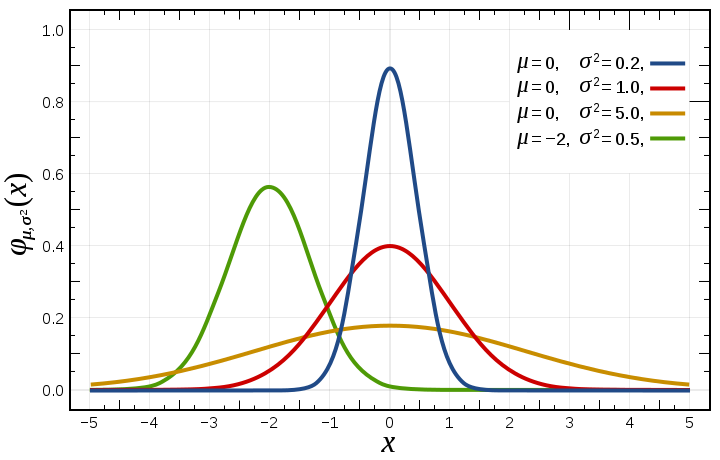

A statistical test that tell us wheter a given distribution is or is not statistically different from the normal distribution. There are many such tests and perhaps one of the most commonly used is called the Jarque-Bera test.

Asset returns are not normally distributed. Deviations from normality can be severe

##### Lab Session - Building Modules

A module in Python is conceptually not much more than a file with python code in it that you can access and run by importing the module.

When you `import` a module, you are reading the file and making the code contained in it accessible through its alias.

Start by creating a new file called `hello.py` and add the following message in there:

```python
message = 'Hello Jim'
```
and then try executing this code:

```python
import hello as h
h.message
```


In [28]:
import hello as h
h.message

Now, let's change the message. Edit the file to now say:

```python
message = 'Hello Jane'
```

and rexecute the code:

```python
import hello as h
h.message
```

In [30]:
h.message

'Hello Jim'

What went wrong?

Since the contents of modules dont usually change very much (except during module development) Python is smart about importing modules and once a module is imported, it doesnt bother re-importing the module. Normally, this is what you want, but in our case when we are developing the module we want to force the module to geet automatically reloaded everytime it changes.

Fortunately, there is a _magic_ command sequence that does exactly that. First, we have to load an extension called `autoreload` by executing the _magic command_ `%load_ext autoreload`. Once you have loaded that extension, you now have access to a new _magic command_ called `%autoreload` which supports different modes of autoreload. The mode we want for now is to automatically reload anything that changes, which is mode 2. So, you need to execute:

```python
%load_ext autoreload
%autoreload 2
```

Now try executing:

```python
h.message
```

and you will see that future edits to the hello file will immediately be reloaded.

In [5]:
%load_ext autoreload
%autoreload 2

In [2]:
import edhec_risk_kit as erk

returns = erk.get_ffme_returns()
returns.head()

SmallCap  LargeCap
1926-07   -0.0145    0.0329
1926-08    0.0512    0.0370
1926-09    0.0093    0.0067
1926-10   -0.0484   -0.0243
1926-11   -0.0078    0.0270

In [3]:
erk.drawdown(returns['SmallCap'])['Drawdown'].min()

-0.8330007793945303

##### Downside Risk Measures

Semi-deviation is the volatility of the sub-sample of below-average or below-zero returns. Volatility or uncertanty does not bother investors when it is on the upside. What really bothers investors is when there's uncertainty or volatility on the downside.

$$ \sigma_{semi} = \sqrt{\frac{1}{N} \sum_{R_t \leq \bar{R}} (R_t - \bar{R})^2}$$

Where $N$ is the number of returns that fall below the mean

**Value at Risk: VaR** 

Represents the maximum 'expected' loss over a given time period. Value at risk (VaR) definition maximum potential loss threshold. VaR provides an estimate of potential loss at a given confidence level.

* At a specified confidence level - 99%
* Over a specified holding period - 1 month

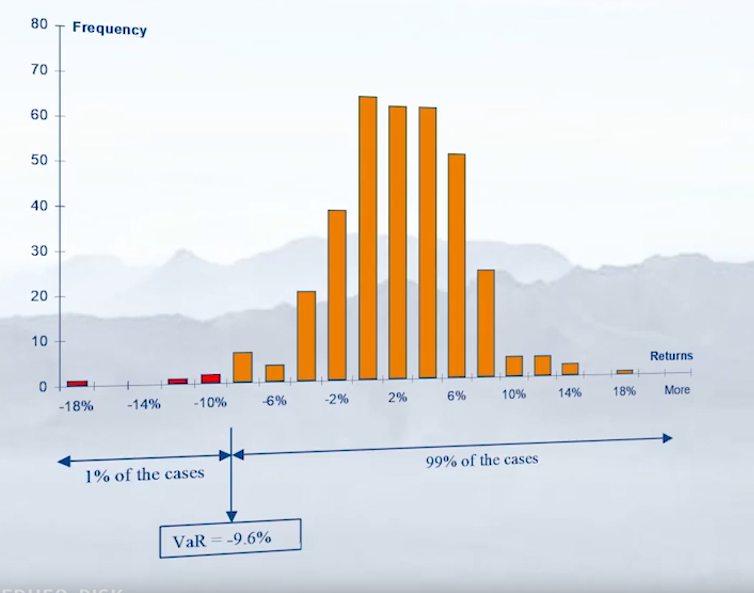

**Beyond VaR or Conditional VaR**

Expected loss beyond VaR

$$ CVaR = -E(R | R \leq -VaR) = \frac{-\int_{-\infty}^{-VaR} x \cdot f_R(x)dx}{F_R (-VaR)}$$

The CVaR is given by the average loss beyond the VaR

##### Lab Session - Deviations from Normality

We'll develop the code for skewness and kurtosis even though these are already available in the scipy.stats module, and then we'll apply them to hedge fund index returns.

We'll also look at using scipy.stats module to apply the Jarque-Bera test for normality, and apply them to different return series.

In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import edhec_risk_kit as erk

In [3]:
hfi = erk.get_hfi_returns()

d:\OneDrive - Universidad Nacional de Colombia\Investment Management with Python and Machine Learning\Introduction to Portfolio Construction and Analysis with Python\edhec_risk_kit.py:47: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  hfi = pd.read_csv('data/edhec-hedgefundindices.csv',


**Skewness**

Intuitively, a negative skew means that you get more negative returns than you would have expected if the returns were distributed like the normal distribution.

Another way of thinking about it is if that returns are normally distributed, the mean and the median would be very close.

However, if they are negatively skewed, the expected value i.e. the mean is less than the median. If they are positively skewed, the expected value (again, the mean) is greater than the median.

In [4]:
pd.concat([hfi.mean(), hfi.median(), hfi.mean() > hfi.median()], axis = 'columns')

0       1      2
Convertible Arbitrage   0.005508  0.0065  False
CTA Global              0.004074  0.0014   True
Distressed Securities   0.006946  0.0089  False
Emerging Markets        0.006253  0.0096  False
Equity Market Neutral   0.004498  0.0051  False
Event Driven            0.006344  0.0084  False
Fixed Income Arbitrage  0.004365  0.0055  False
Global Macro            0.005403  0.0038   True
Long/Short Equity       0.006331  0.0079  False
Merger Arbitrage        0.005356  0.0060  False
Relative Value          0.005792  0.0067  False
Short Selling          -0.001701 -0.0053   True
Funds Of Funds          0.004262  0.0052  False

Recall that the skewness is given by:

$$ S(R) = \frac{E[(R-E(R))^3]}{\sigma_R^3} $$

In [12]:
def skewness(r):
    """
    Alternative to scipy.stats.skew()
    Computes the skewness of the supplied Series or DataFrame
    Returns a float or a Series
    """
    demeaned_r = r - r.mean()
    # use the population standard deviation, so set dof=0
    sigma_r = r.std(ddof=0)
    exp = (demeaned_r**3).mean()
    return exp/sigma_r**3

In [15]:
erk.skewness(hfi).sort_values()

Fixed Income Arbitrage   -3.940320
Convertible Arbitrage    -2.639592
Equity Market Neutral    -2.124435
Relative Value           -1.815470
Event Driven             -1.409154
Merger Arbitrage         -1.320083
Distressed Securities    -1.300842
Emerging Markets         -1.167067
Long/Short Equity        -0.390227
Funds Of Funds           -0.361783
CTA Global                0.173699
Short Selling             0.767975
Global Macro              0.982922
dtype: float64

In [16]:
import scipy.stats

scipy.stats.skew(hfi)

array([-2.63959223,  0.17369864, -1.30084204, -1.16706749, -2.12443538,
       -1.40915356, -3.94032029,  0.98292188, -0.39022677, -1.32008333,
       -1.81546975,  0.76797484, -0.36178308])

In [19]:
normal_rets = np.random.normal(0, 0.15, (263, 1))
normal_rets.mean(), normal_rets.std()

(0.004562776412130796, 0.15245601051031318)

In [20]:
erk.skewness(normal_rets)

-0.01377602720857256

**Kurtosis** 

Intuitively, the kurtosis measures the "fatness" of the tails of the distribution. The normal distribution has a kurtosis of 3 and so if the kurtosis of your returns is less than 3 then it tends to have thinner tails, and if the kurtosis is greater than 3 then the distribution has fatter tails.

Kurtosis is given by:

$$ K(R) = \frac{E[(R-E(R))^4]}{\sigma_R^4} $$


In [21]:
erk.kurtosis(normal_rets)

2.857499309444464

In [24]:
scipy.stats.kurtosis(normal_rets) # This gives the excess kurtosis i.e. kurtosis - 3

array([-0.14250069])

In [25]:
erk.kurtosis(hfi)

Convertible Arbitrage     23.280834
CTA Global                 2.952960
Distressed Securities      7.889983
Emerging Markets           9.250788
Equity Market Neutral     17.218555
Event Driven               8.035828
Fixed Income Arbitrage    29.842199
Global Macro               5.741679
Long/Short Equity          4.523893
Merger Arbitrage           8.738950
Relative Value            12.121208
Short Selling              6.117772
Funds Of Funds             7.070153
dtype: float64

In [26]:
scipy.stats.kurtosis(hfi) # This gives the excess kurtosis i.e. kurtosis - 3 

array([20.28083446, -0.04703963,  4.88998336,  6.25078841, 14.21855526,
        5.03582817, 26.84219928,  2.74167945,  1.52389258,  5.73894979,
        9.12120787,  3.11777175,  4.07015278])

**Running the Jarque-Bera Test for Normality**

The `scipy.stats` module contains a function that runs the _Jarque-Bera_ test on a sequence of numbers. 

In [27]:
scipy.stats.jarque_bera(normal_rets)

SignificanceResult(statistic=0.23084345585420057, pvalue=0.8909903091662476)

The first number is the test statistic and the second number is the one we want. It represents the p-value for the hypothesis test. If you want to run the test at a 1% level of significance, you want this number to be greater than 0.01 to accept the hypothesis that the data is normally distributed, and if that number is less than 0.01 then you must reject the hypothesis of normality.

In this case, since we got a number higher than 0.01 we can accept the hypothesis that the numbers are random. Now, let's try this on our different hedge fund indices.

In [28]:
scipy.stats.jarque_bera(hfi)

SignificanceResult(statistic=25656.585999171337, pvalue=0.0)

Why didn't we get the results for the individual indices? Because the implementation of the test isn't smart enough to realize that we want to treat each column as a separate set of returns. We can write out own wrapper for it to fix that, so let's start by writing a simple wrapper, and adding this code to our python file:

```python
import scipy.stats
def is_normal(r, level=0.01):
    """
    Applies the Jarque-Bera test to determine if a Series is normal or not
    Test is applied at the 1% level by default
    Returns True if the hypothesis of normality is accepted, False otherwise
    """
    statistic, p_value = scipy.stats.jarque_bera(r)
    return p_value > level
```

In [29]:
erk.is_normal(normal_rets)

True

There are a few different ways to handle the problem. The first is to use the `.aggregate` method on a dataframe, that takes a function as an argument and applies that function to each column:

In [32]:
hfi.apply(erk.is_normal)

Convertible Arbitrage     False
CTA Global                 True
Distressed Securities     False
Emerging Markets          False
Equity Market Neutral     False
Event Driven              False
Fixed Income Arbitrage    False
Global Macro              False
Long/Short Equity         False
Merger Arbitrage          False
Relative Value            False
Short Selling             False
Funds Of Funds            False
dtype: bool

However, we can fix this in our wrapper so that we have a uniform interface to test normality:

```python
import scipy.stats
def is_normal(r, level=0.01):
    """
    Applies the Jarque-Bera test to determine if a Series is normal or not
    Test is applied at the 1% level by default
    Returns True if the hypothesis of normality is accepted, False otherwise
    """
    if isinstance(r, pd.DataFrame):
        return r.aggregate(is_normal)
    else:
        statistic, p_value = scipy.stats.jarque_bera(r)
        return p_value > level
```

**Testing CRSP SmallCap and Large Cap returns for Normality**

Let's see whether any of the returns we've been studying so far pass the normality hypothesis.

In [40]:
ffme = erk.get_ffme_returns()
erk.skewness(ffme)

SmallCap    4.410739
LargeCap    0.233445
dtype: float64

In [41]:
erk.kurtosis(ffme)

SmallCap    46.845008
LargeCap    10.694654
dtype: float64

In [43]:
erk.is_normal(ffme)

SmallCap    False
LargeCap    False
dtype: bool

##### Estimating VaR

There're at least four standard methods for calculating VaR.

* Method 1: Historical (non parametric)
* Method 2: Variance-Covariance (parametric Gaussian)
* Method 3: parametric non-Gaussian
* Method 4: Cornish-Fisher (semi-parametric)

**Historical metodology** 

Calculation of VaR based on the distribution of historical changes in the value of the current portfolio under market prices over the specified historical observation window

**Parametric Gaussian Methodology** 

Calculation of VaR based on portfolio volatility, i.e., on volatilities and correlations of components

$$ VaR_\alpha = -(\mu+Z_\alpha \sigma)$$ 



In [50]:
-(0.5 + -1.65*4)

6.1

Assuming normal distributions may understate risk

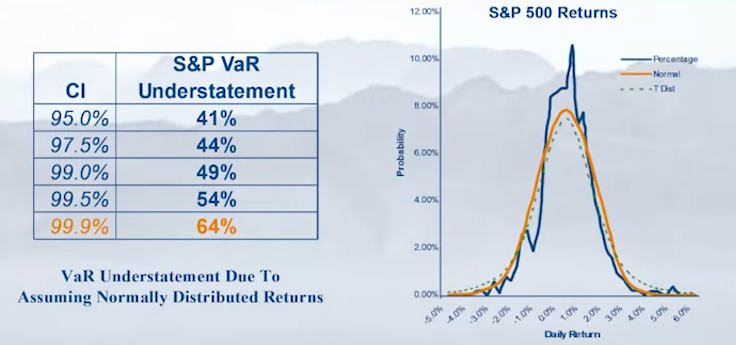

Assuming a Gaussian distribution is not a good idea if your focus is on the tail of the distribution because the Gaussian distribution has very thin tails and that's not what an actual return distribution look like.

**Parametric non-Gaussian Methodology** 

Parametric is good because mitigates the problem of estimation risk at the cost of model risk. Can be parametric but non-Gaussian, i.e., Pareto, Student, Loggamma, Frechet.

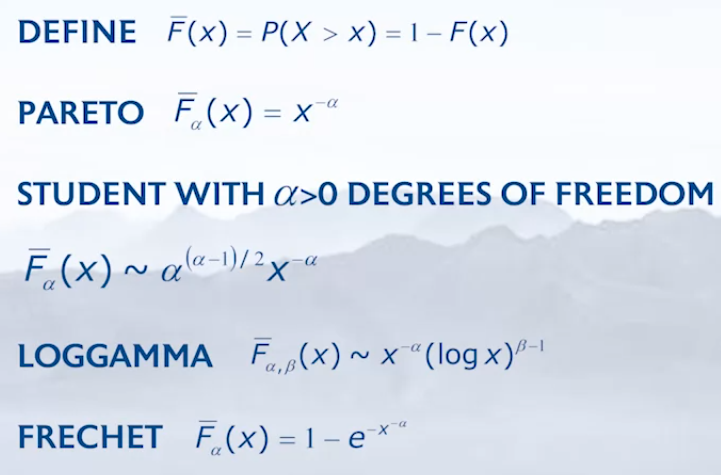

**Cornish-Fisher Methodology** 

An alternative to parametric exists semi-parametric approach. The Cornish-Fisher VaR is some kind of semi-parametric approach that does not force you to assume any particular return distribution. We use the Cornish-Fisher expansion: 

$$\tilde{z_\alpha} = z_\alpha + \frac{1}{6}(z_\alpha^2-1)S + \frac{1}{24}(z_\alpha^3-3z_\alpha)(K-3) - \frac{1}{36}(2z_\alpha^3-5z_\alpha)S^2 $$

$$ VaR_{mod}(1-\alpha) = -(\mu + \tilde{z_\alpha}\sigma)  $$



##### Lab Session - Semi Deviation, VaR and CVaR

In [13]:
import pandas as pd
import edhec_risk_kit as erk
%load_ext autoreload
%autoreload 2

In [12]:
hfi = erk.get_hfi_returns()

d:\OneDrive - Universidad Nacional de Colombia\Investment Management with Python and Machine Learning\Introduction to Portfolio Construction and Analysis with Python\edhec_risk_kit.py:47: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  hfi = pd.read_csv('data/edhec-hedgefundindices.csv',


In [3]:
hfi.std(ddof=0)

Convertible Arbitrage     0.016536
CTA Global                0.023290
Distressed Securities     0.017009
Emerging Markets          0.032476
Equity Market Neutral     0.008115
Event Driven              0.016712
Fixed Income Arbitrage    0.011517
Global Macro              0.014694
Long/Short Equity         0.019897
Merger Arbitrage          0.009600
Relative Value            0.011462
Short Selling             0.047655
Funds Of Funds            0.015536
dtype: float64

In [7]:
hfi[hfi < 0].std(ddof = 0)

Convertible Arbitrage     0.019540
CTA Global                0.012443
Distressed Securities     0.015185
Emerging Markets          0.028039
Equity Market Neutral     0.009566
Event Driven              0.015429
Fixed Income Arbitrage    0.017763
Global Macro              0.006579
Long/Short Equity         0.014051
Merger Arbitrage          0.008875
Relative Value            0.012244
Short Selling             0.027283
Funds Of Funds            0.012122
dtype: float64

In [8]:
erk.semideviation(hfi) # With previous formula

Convertible Arbitrage     0.019540
CTA Global                0.012443
Distressed Securities     0.015185
Emerging Markets          0.028039
Equity Market Neutral     0.009566
Event Driven              0.015429
Fixed Income Arbitrage    0.017763
Global Macro              0.006579
Long/Short Equity         0.014051
Merger Arbitrage          0.008875
Relative Value            0.012244
Short Selling             0.027283
Funds Of Funds            0.012122
dtype: float64

In [9]:
erk.semideviation(hfi)

Convertible Arbitrage     0.019540
CTA Global                0.012443
Distressed Securities     0.015185
Emerging Markets          0.028039
Equity Market Neutral     0.009566
Event Driven              0.015429
Fixed Income Arbitrage    0.017763
Global Macro              0.006579
Long/Short Equity         0.014051
Merger Arbitrage          0.008875
Relative Value            0.012244
Short Selling             0.027283
Funds Of Funds            0.012122
dtype: float64

**VaR and CVaR**

We'll look at three different ways to compute Value At Risk

- Historic VaR
- Parametric VaR - Gaussian
- Modified Cornish-Fisher VaR

To compute the historic VaR at a certain level, say 5%, all we have to do is to find the number such that 5% of the returns fall below that number and 95% of the returns fall above that number. In other words, we want the 5 percentile return.

Fortunately, numpy has a `np.percentile` function that computes exactly that.



In [64]:
np.percentile(hfi, 5, axis = 0)

array([-0.01576, -0.03169, -0.01966, -0.04247, -0.00814, -0.02535,
       -0.00787, -0.01499, -0.02598, -0.01047, -0.01174, -0.06783,
       -0.02047])

In [10]:
def var_historic(r, level = 5):
    '''
    Returns the historic Value at Risk at a specified level (5% default) i.e. returns the number such that
    'level' percent of the returns fall below that number, and the (100-level) percent are above
    '''

    if isinstance(r, pd.DataFrame):
        return r.aggregate(var_historic)
    elif isinstance(r, pd.Series):
        return -np.percentile(r, level)
    else:
        raise TypeError('Expected r to be a Series or DataFrame')

In [14]:
var_historic(hfi)

Convertible Arbitrage     0.01576
CTA Global                0.03169
Distressed Securities     0.01966
Emerging Markets          0.04247
Equity Market Neutral     0.00814
Event Driven              0.02535
Fixed Income Arbitrage    0.00787
Global Macro              0.01499
Long/Short Equity         0.02598
Merger Arbitrage          0.01047
Relative Value            0.01174
Short Selling             0.06783
Funds Of Funds            0.02047
dtype: float64

In [15]:
erk.var_historic(hfi)

Convertible Arbitrage     0.01576
CTA Global                0.03169
Distressed Securities     0.01966
Emerging Markets          0.04247
Equity Market Neutral     0.00814
Event Driven              0.02535
Fixed Income Arbitrage    0.00787
Global Macro              0.01499
Long/Short Equity         0.02598
Merger Arbitrage          0.01047
Relative Value            0.01174
Short Selling             0.06783
Funds Of Funds            0.02047
dtype: float64

In [16]:
from scipy.stats import norm

In [17]:
z = norm.ppf(.05)

In [18]:
-(hfi.mean() + z*hfi.std(ddof = 0))

Convertible Arbitrage     0.021691
CTA Global                0.034235
Distressed Securities     0.021032
Emerging Markets          0.047164
Equity Market Neutral     0.008850
Event Driven              0.021144
Fixed Income Arbitrage    0.014579
Global Macro              0.018766
Long/Short Equity         0.026397
Merger Arbitrage          0.010435
Relative Value            0.013061
Short Selling             0.080086
Funds Of Funds            0.021292
dtype: float64

In [19]:
erk.var_gaussian(hfi)

Convertible Arbitrage     0.021691
CTA Global                0.034235
Distressed Securities     0.021032
Emerging Markets          0.047164
Equity Market Neutral     0.008850
Event Driven              0.021144
Fixed Income Arbitrage    0.014579
Global Macro              0.018766
Long/Short Equity         0.026397
Merger Arbitrage          0.010435
Relative Value            0.013061
Short Selling             0.080086
Funds Of Funds            0.021292
dtype: float64

<Axes: title={'center': 'EDHEC Hedge Fund Indicies: VaR'}>

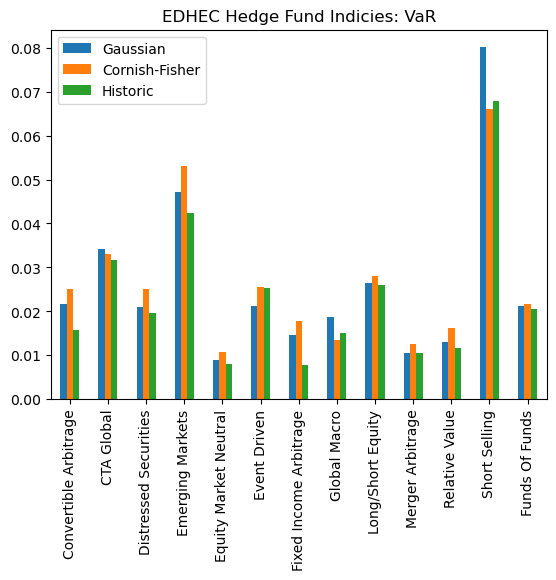

In [30]:
var_list = [erk.var_gaussian(hfi), erk.var_gaussian(hfi, modified = True), erk.var_historic(hfi)]
comparison = pd.concat(var_list, axis = 1)
comparison.columns = ['Gaussian', 'Cornish-Fisher', 'Historic']
comparison.plot.bar(title = 'EDHEC Hedge Fund Indicies: VaR')

**Beyond VaR aka CVaR**

In [31]:
erk.cvar_historic(hfi)

Convertible Arbitrage     0.036550
CTA Global                0.041264
Distressed Securities     0.036429
Emerging Markets          0.072364
Equity Market Neutral     0.016879
Event Driven              0.038336
Fixed Income Arbitrage    0.028257
Global Macro              0.020629
Long/Short Equity         0.041943
Merger Arbitrage          0.019143
Relative Value            0.024650
Short Selling             0.096821
Funds Of Funds            0.033207
dtype: float64

In [32]:
erk.var_historic(hfi)

Convertible Arbitrage     0.01576
CTA Global                0.03169
Distressed Securities     0.01966
Emerging Markets          0.04247
Equity Market Neutral     0.00814
Event Driven              0.02535
Fixed Income Arbitrage    0.00787
Global Macro              0.01499
Long/Short Equity         0.02598
Merger Arbitrage          0.01047
Relative Value            0.01174
Short Selling             0.06783
Funds Of Funds            0.02047
dtype: float64

<Axes: title={'center': 'EDHEC Hedge Fund Indicies: VaR and CVaR'}>

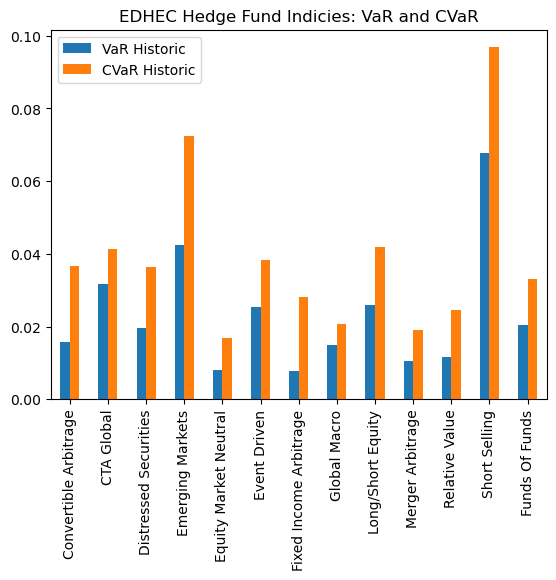

In [33]:
cvar_list = [erk.var_historic(hfi), erk.cvar_historic(hfi)]
comparison = pd.concat(cvar_list, axis = 1)
comparison.columns = ['VaR Historic', 'CVaR Historic']
comparison.plot.bar(title = 'EDHEC Hedge Fund Indicies: VaR and CVaR')

### **An Introduction to Portfolio Optimization**

**Learning Objectives**

* Understand asset optimization
* Understand the concept of the Efficient Frontier with multiple assets
* Introduction to the Quadratic Programming Optimizer
* Introducing the risk-free asset
* Analyse sensitivity to input parameters (lack of robustness)

#### **Section 3 - Introduction to Optimization and The Efficient Frontier**

##### The Only Free Lunch in Finance

We return to the single period framework and look at the risk and return of a portfolio of assets starting with a simple 2-asset portfolio

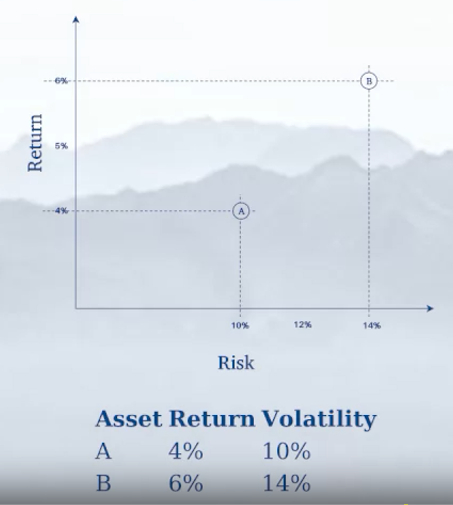

What's the return and volatility of a combination of $A$ and $B$?

A portfolio that is $100\%$ in $A$ and $0\%$ in $B$: The risk and return of that portfolio is the same as the risk and return of $A$

What if we have $50\%$ in $A$ and $50\%$ in $B$

The return on a portfolio is nothing more than the weighted average of all the components of the portfolio. The information about the volatility of the porfolio can't be answered with the information we have. If A and B are perfectly correlated, then the volatility of a portfolio that is 50% in A and 50% in B is the average of the volatilities of A and B. The more de-correlated they are, the less the volatility of that portfolio

$$ R(w_A, w_B) = w_A \cdot R_a + w_B \cdot R_b$$

$$ \sigma^2(w_A, w_B) = \sigma^2_A w^2_A + \sigma^2_B w^2_B + 2 w_A w_B \sigma_A \sigma_B \rho_{A,B}$$

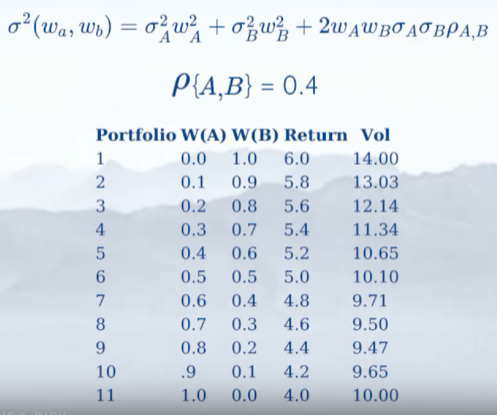

In [20]:
portfolio_A_B = pd.DataFrame({'W(A)': np.arange(0, 1.1, 0.1),\
    'W(B)': np.arange(0, 1.1, 0.1)[::-1]})

In [37]:
return_A = 0.04
return_B = 0.06
vol_A = 0.10
vol_B = 0.14
corr_AB = 0.4

portfolio_A_B['Return (%)'] = (portfolio_A_B['W(A)'] * return_A + portfolio_A_B['W(B)'] * return_B)*100

portfolio_A_B['Vol'] = round(np.sqrt(vol_A**2 * portfolio_A_B['W(A)']**2 + vol_B**2 * portfolio_A_B['W(B)']**2 + \
    2*portfolio_A_B['W(A)']*portfolio_A_B['W(B)']*vol_A*vol_B*corr_AB)*100, 2)

portfolio_A_B

W(A)  W(B)  Return  Return (%)    Vol
0    0.0   1.0   0.060         6.0  14.00
1    0.1   0.9   0.058         5.8  13.03
2    0.2   0.8   0.056         5.6  12.14
3    0.3   0.7   0.054         5.4  11.34
4    0.4   0.6   0.052         5.2  10.65
5    0.5   0.5   0.050         5.0  10.10
6    0.6   0.4   0.048         4.8   9.71
7    0.7   0.3   0.046         4.6   9.50
8    0.8   0.2   0.044         4.4   9.47
9    0.9   0.1   0.042         4.2   9.65
10   1.0   0.0   0.040         4.0  10.00

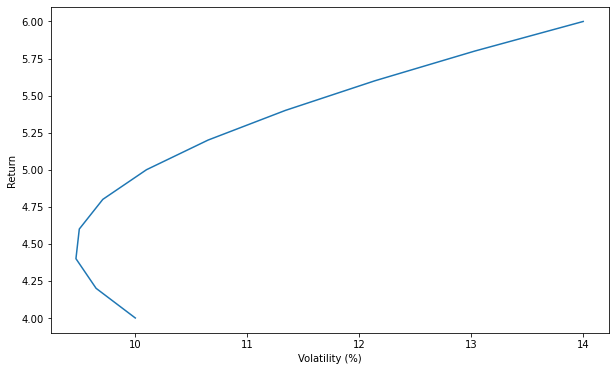

In [38]:
plt.figure(figsize = (10, 6))
plt.plot(portfolio_A_B['Vol'], portfolio_A_B['Return (%)'])
plt.ylabel('Return')
plt.xlabel('Volatility (%)')
plt.show()

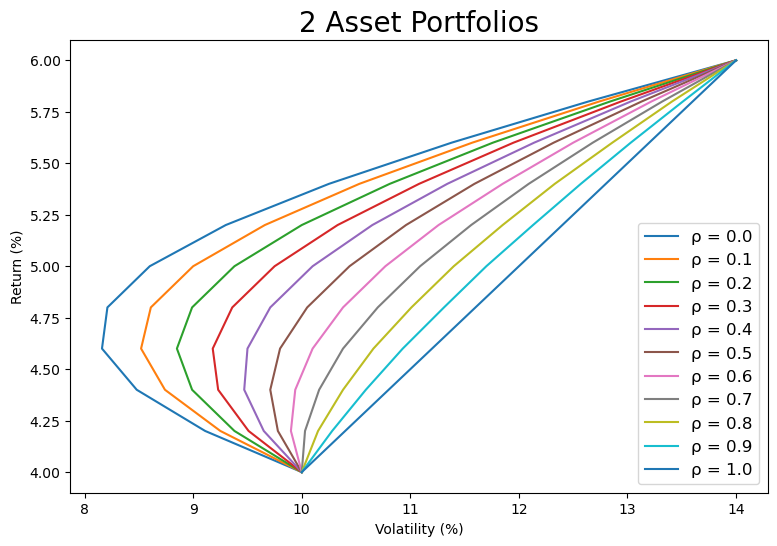

In [82]:
port = pd.DataFrame({'W(A)': np.arange(0, 1.1, 0.1), 'W(B)': np.arange(0, 1.1, 0.1)[::-1]})
port['Return (%)'] = (port['W(A)'] * return_A + port['W(B)'] * return_B)*100

for corr in np.arange(0, 1.1, 0.1):
    port[f'Vol p = {round(corr, 1)}'] = round(np.sqrt(vol_A**2 * port['W(A)']**2 + vol_B**2 * port['W(B)']**2 + \
        2*port['W(A)']*port['W(B)']*vol_A*vol_B*corr)*100, 2)

s = []
for i in np.arange(0, 1.1, 0.1):
    s.append(f'Vol p = {round(i, 1)}')

plt.figure(figsize = (9, 6), dpi = 100)

for corr, i in zip(s, [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]):
    plt.plot(port[corr], port['Return (%)'], label = f'ρ = {i}')

plt.ylabel('Return (%)')
plt.xlabel('Volatility (%)')
plt.title('2 Asset Portfolios', fontsize = 20)
plt.legend(fontsize = 12)
plt.show()


##### Lab Session - Efficient Frontier Part I

We are going to learn how to compute the efficient frontier when we have a set of expected returns, volatilities (or variances) and correlations (or covariances). It's a fair question as to how we can get these numbers for the future, but for now, we'll assume that historic returns are a reasonable estimate. In future sections, we'll learn how to improve on it.

Let's start by importing a new dataset. This is the Ken French dataset of the returns of 30 different industry portfolios.

This datafile has a number of minor problems that we'll sort through as we go:

In [4]:
ind = pd.read_csv('data/ind30_m_vw_rets.csv', header = 0, index_col = 0, parse_dates = True)/100
ind.index = pd.to_datetime(ind.index, format = '%Y%m').to_period('M')
ind.head()

Food    Beer    Smoke   Games   Books   Hshld   Clths   Hlth   \
1926-07  0.0056 -0.0519  0.0129  0.0293  0.1097 -0.0048  0.0808  0.0177   
1926-08  0.0259  0.2703  0.0650  0.0055  0.1001 -0.0358 -0.0251  0.0425   
1926-09  0.0116  0.0402  0.0126  0.0658 -0.0099  0.0073 -0.0051  0.0069   
1926-10 -0.0306 -0.0331  0.0106 -0.0476  0.0947 -0.0468  0.0012 -0.0057   
1926-11  0.0635  0.0729  0.0455  0.0166 -0.0580 -0.0054  0.0187  0.0542   

          Chems   Txtls  ...   Telcm   Servs   BusEq   Paper   Trans   Whlsl  \
1926-07  0.0814  0.0039  ...  0.0083  0.0922  0.0206  0.0770  0.0193 -0.2379   
1926-08  0.0550  0.0814  ...  0.0217  0.0202  0.0439 -0.0238  0.0488  0.0539   
1926-09  0.0533  0.0231  ...  0.0241  0.0225  0.0019 -0.0554  0.0005 -0.0787   
1926-10 -0.0476  0.0100  ... -0.0011 -0.0200 -0.0109 -0.0508 -0.0264 -0.1538   
1926-11  0.0520  0.0311  ...  0.0163  0.0377  0.0364  0.0384  0.0160  0.0467   

          Rtail   Meals   Fin     Other  
1926-07  0.0007  0.0187  0.0037  0.0520  
1926-08 -0.0075 -0.0013  0.0446  0.0676  
1926-09  0.0025 -0.0056 -0.0123 -0.0386  
1926-10 -0.0220 -0.0411 -0.0516 -0.0849  
1926-11  0.0652  0.0433  0.0224  0.0400  

[5 rows x 30 columns]

In [86]:
ind.columns

Index(['Food ', 'Beer ', 'Smoke', 'Games', 'Books', 'Hshld', 'Clths', 'Hlth ',
       'Chems', 'Txtls', 'Cnstr', 'Steel', 'FabPr', 'ElcEq', 'Autos', 'Carry',
       'Mines', 'Coal ', 'Oil  ', 'Util ', 'Telcm', 'Servs', 'BusEq', 'Paper',
       'Trans', 'Whlsl', 'Rtail', 'Meals', 'Fin  ', 'Other'],
      dtype='object')

Note that the column names have embedded spaces. We can strip out the leading and trailing spaces in the Series by using the `.str.strip` method.

In [89]:
ind.columns = ind.columns.str.strip()
ind.columns

Index(['Food', 'Beer', 'Smoke', 'Games', 'Books', 'Hshld', 'Clths', 'Hlth',
       'Chems', 'Txtls', 'Cnstr', 'Steel', 'FabPr', 'ElcEq', 'Autos', 'Carry',
       'Mines', 'Coal', 'Oil', 'Util', 'Telcm', 'Servs', 'BusEq', 'Paper',
       'Trans', 'Whlsl', 'Rtail', 'Meals', 'Fin', 'Other'],
      dtype='object')

This looks good, so let's add the following code to our module for future use:

```python
def get_ind_returns():
    """
    Load and format the Ken French 30 Industry Portfolios Value Weighted Monthly Returns
    """
    ind = pd.read_csv("data/ind30_m_vw_rets.csv", header=0, index_col=0)/100
    ind.index = pd.to_datetime(ind.index, format="%Y%m").to_period('M')
    ind.columns = ind.columns.str.strip()
    return ind
```

and then test it by loading the module as usual.

In [2]:
%load_ext autoreload
%autoreload 2

In [95]:
ind = erk.get_ind_returns()
ind.shape

(1110, 30)

<AxesSubplot:>

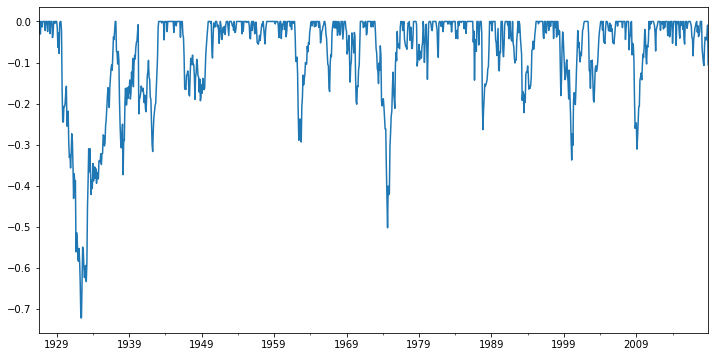

In [98]:
erk.drawdown(ind['Food'])['Drawdown'].plot(figsize=(12, 6))

In [100]:
cols_of_interest = ['Food', 'Smoke', 'Coal', 'Beer', 'Fin']
erk.var_gaussian(ind[cols_of_interest], modified = True)

Food     0.061207
Smoke    0.080292
Coal     0.047359
Beer     0.033881
Fin      0.075199
dtype: float64

<AxesSubplot:>

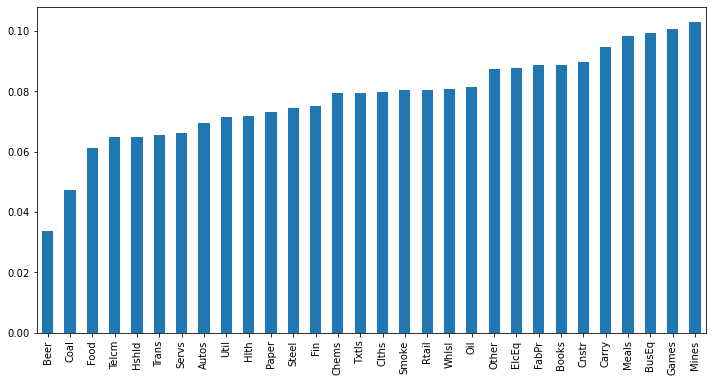

In [104]:
erk.var_gaussian(ind, modified = True).sort_values().plot.bar(figsize = (12, 6))

Let's use this as an opportunity to write functions for annualized returns, volatility and sharpe ratios. Add the following to the `edhec_risk_kit.py` file:

```python
def annualize_rets(r, periods_per_year):
    """
    Annualizes a set of returns
    We should infer the periods per year
    but that is currently left as an exercise
    to the reader :-)
    """
    compounded_growth = (1+r).prod()
    n_periods = r.shape[0]
    return compounded_growth**(periods_per_year/n_periods)-1

def annualize_vol(r, periods_per_year):
    """
    Annualizes the vol of a set of returns
    We should infer the periods per year
    but that is currently left as an exercise
    to the reader :-)
    """
    return r.std()*(periods_per_year**0.5)

def sharpe_ratio(r, riskfree_rate, periods_per_year):
    """
    Computes the annualized sharpe ratio of a set of returns
    """
    # convert the annual riskfree rate to per period
    rf_per_period = (1+riskfree_rate)**(1/periods_per_year)-1
    excess_ret = r - rf_per_period
    ann_ex_ret = annualize_rets(excess_ret, periods_per_year)
    ann_vol = annualize_vol(r, periods_per_year)
    return ann_ex_ret/ann_vol

```

<AxesSubplot:title={'center':'Industry Sharpe Ratios from 1926-2018'}>

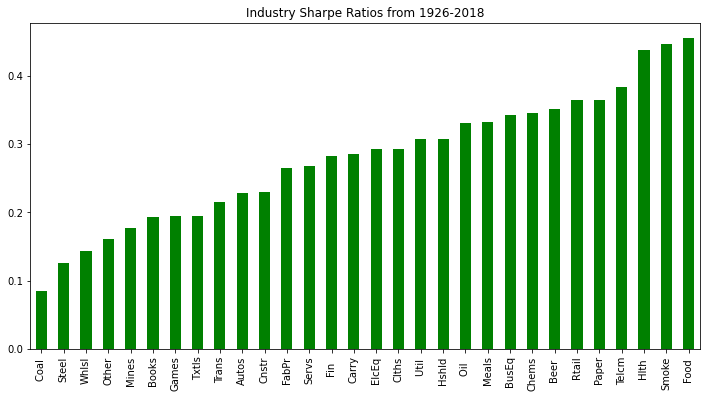

In [5]:
erk.sharpe_ratio(ind, 0.03, 12).sort_values().plot.bar(title = 'Industry Sharpe Ratios from 1926-2018',
color = 'green', figsize = (12, 6))

<AxesSubplot:title={'center':'Industry Sharpe Ratios from 2000-2018'}>

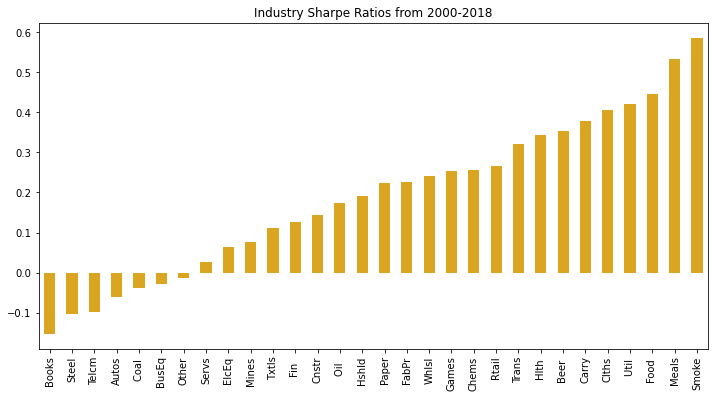

In [6]:
erk.sharpe_ratio(ind['2000':], 0.03, 12).sort_values().plot.bar(title = 'Industry Sharpe Ratios from 2000-2018',
color = 'goldenrod', figsize = (12, 6))

**Expected Returns and the Covariance Matrix**

Generating the efficient frontier requires a set of expected returns and a covariance matrix. For now, let's assume that we can estiamte these simply by looking back in time and naively assuming they will hold in the future. Clearly, they will not, but we will have plenty of time to dig into that in future lectures. For the moment, assume that our naive method of estimating these parameters will suffice.

We can generate an estimate of expected returns using the `annualize_rets()` function, that returns a vector of expected returns. For instance, let's generate the set of expected returns based on historic returns from the 5 year period from 1996 through 2000:

In [7]:
er = erk.annualize_rets(ind['1995':'2000'], 12)

<AxesSubplot:>

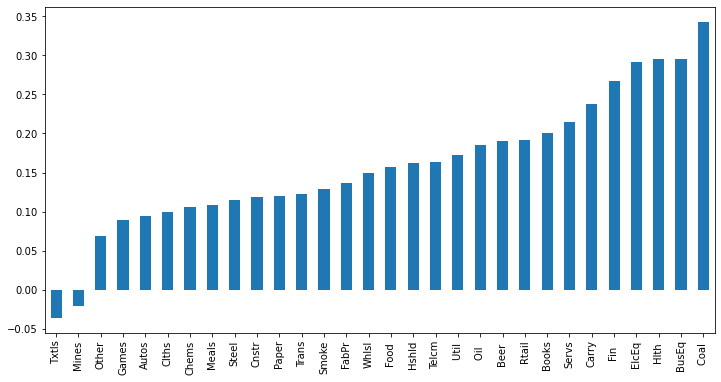

In [10]:
er.sort_values().plot.bar(figsize = (12, 6))

Finally, let's generate the covariance matrix. Fortunately, this is easy enough to do using the `.cov` method:

In [11]:
cov = ind['1995':'2000'].cov()
cov.shape

(30, 30)

In [12]:
cov

Food      Beer      Smoke     Games     Books     Hshld     Clths  \
Food   0.002287  0.002077  0.001757  0.000701  0.000886  0.001208  0.001474   
Beer   0.002077  0.004599  0.001143  0.001147  0.000765  0.002447  0.001415   
Smoke  0.001757  0.001143  0.007130  0.000296 -0.000099  0.000981  0.000761   
Games  0.000701  0.001147  0.000296  0.003271  0.001485  0.001018  0.001814   
Books  0.000886  0.000765 -0.000099  0.001485  0.002302  0.000876  0.002037   
Hshld  0.001208  0.002447  0.000981  0.001018  0.000876  0.002849  0.001046   
Clths  0.001474  0.001415  0.000761  0.001814  0.002037  0.001046  0.004896   
Hlth   0.001105  0.001689  0.000877  0.001219  0.000657  0.001253  0.000759   
Chems  0.001253  0.001292  0.000687  0.001547  0.001559  0.001226  0.002547   
Txtls  0.001021  0.001721  0.000555  0.001291  0.001362  0.001172  0.002105   
Cnstr  0.001282  0.001945  0.001181  0.001723  0.001531  0.001770  0.002486   
Steel  0.000027  0.000131  0.000167  0.002670  0.001797  0.001050  0.001702   
FabPr  0.000613  0.000666  0.000668  0.002498  0.001704  0.001125  0.002430   
ElcEq  0.001146  0.001107 -0.000013  0.001980  0.002084  0.001426  0.002239   
Autos  0.000547  0.001296  0.000223  0.001994  0.001550  0.001466  0.002521   
Carry  0.001419  0.001804  0.001485  0.001644  0.001301  0.001704  0.002873   
Mines  0.000829  0.000272  0.001311  0.001600  0.001281  0.000598  0.002467   
Coal   0.000034  0.001261 -0.000544  0.001557  0.002051  0.001787  0.002433   
Oil    0.000933  0.000672  0.000849  0.000968  0.000868  0.000541  0.001646   
Util   0.000858  0.000631  0.001118  0.000023  0.000455  0.000350  0.000646   
Telcm  0.000610  0.000978  0.000057  0.001615  0.001627  0.000889  0.001263   
Servs  0.000211  0.000400 -0.000266  0.002399  0.001996  0.001111  0.001401   
BusEq -0.000280  0.000028 -0.000300  0.002935  0.001624  0.000906  0.000746   
Paper  0.001205  0.001455  0.001061  0.001615  0.001481  0.001594  0.002683   
Trans  0.001312  0.001974  0.000241  0.001438  0.001576  0.001366  0.002466   
Whlsl  0.000633  0.000609  0.001363  0.001681  0.001205  0.000578  0.001654   
Rtail  0.001165  0.001442  0.000069  0.001649  0.001995  0.001157  0.002607   
Meals  0.001085  0.001634  0.000590  0.001383  0.001026  0.001076  0.002229   
Fin    0.001839  0.002236  0.001117  0.002080  0.001979  0.001652  0.002699   
Other  0.000898  0.001196  0.001418  0.002088  0.001283  0.001322  0.001974   

          Hlth      Chems     Txtls  ...     Telcm     Servs     BusEq  \
Food   0.001105  0.001253  0.001021  ...  0.000610  0.000211 -0.000280   
Beer   0.001689  0.001292  0.001721  ...  0.000978  0.000400  0.000028   
Smoke  0.000877  0.000687  0.000555  ...  0.000057 -0.000266 -0.000300   
Games  0.001219  0.001547  0.001291  ...  0.001615  0.002399  0.002935   
Books  0.000657  0.001559  0.001362  ...  0.001627  0.001996  0.001624   
Hshld  0.001253  0.001226  0.001172  ...  0.000889  0.001111  0.000906   
Clths  0.000759  0.002547  0.002105  ...  0.001263  0.001401  0.000746   
Hlth   0.002252  0.000444  0.000538  ...  0.001093  0.001390  0.001264   
Chems  0.000444  0.002944  0.001705  ...  0.000860  0.001072  0.000935   
Txtls  0.000538  0.001705  0.002882  ...  0.000790  0.000582  0.000685   
Cnstr  0.001217  0.001829  0.001648  ...  0.001488  0.002169  0.001968   
Steel  0.000836  0.002327  0.001321  ...  0.001987  0.003934  0.005049   
FabPr  0.000768  0.002273  0.001576  ...  0.001428  0.002647  0.003732   
ElcEq  0.001108  0.001560  0.001102  ...  0.002058  0.003312  0.002968   
Autos  0.000851  0.001882  0.001811  ...  0.001544  0.001800  0.002273   
Carry  0.000755  0.002374  0.001842  ...  0.000845  0.001082  0.001261   
Mines  0.001103  0.002345  0.001274  ...  0.001456  0.002260  0.002199   
Coal   0.001549  0.001910  0.000652  ...  0.000912  0.002373  0.002643   
Oil    0.000523  0.001843  0.001104  ...  0.000394  0.001002  0.000920   
Util   0.000543  0.000545  0.000777  ...  0.000136 -0.000596 -0.001000   
Telcm 

##### Markowitz Optimization and the Efficient Frontier

Let's introduce a third asset C

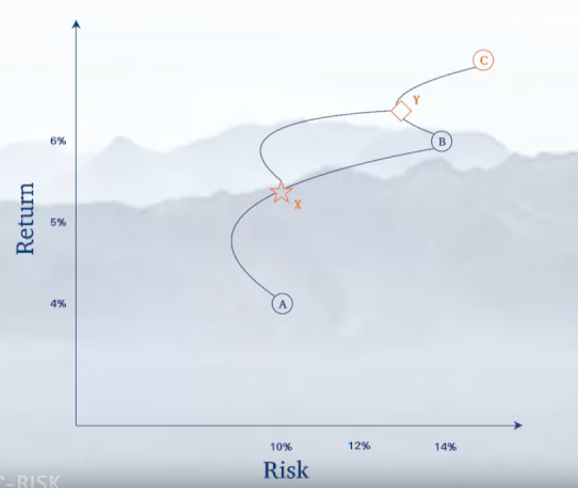

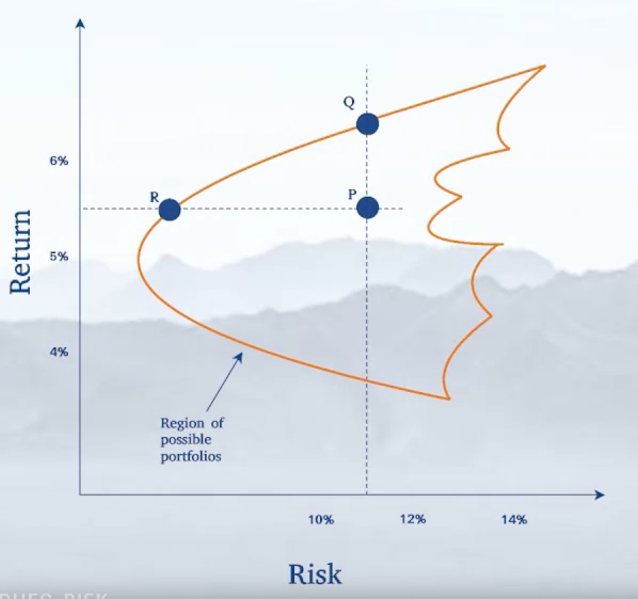

Portfolios on the edge represent the best you can do either in terms of expected return or expected volatility. The efficient frontier represents the portfolios that offer the lowest volatility for a given level of return or they also represent the portfolio of highest expected return for a given level of volatility.

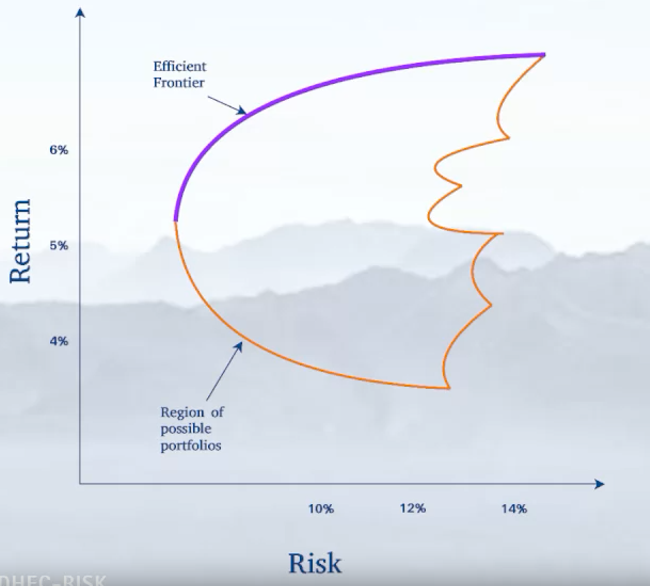

##### Applying Quadprog to draw The Efficient Frontier

Given a set of asset returns, volatilities and correlations we can plot the efficient frontier. We need to have expressions for the return and volatility of a portfolio:

$$ R_p = \sum_{i=1}^{k} w_i R_i $$

The expression for portfolio variance $\sigma^2$ is a generalization of the formula we've already seen in the 2-asset case:

$$ \sigma_p^2 = \sum_{i=1}^{k}\sum_{j=1}^{k} w_i w_j \sigma_i \sigma_j \rho_{ij} $$

$$ \sigma_p^2 = \sum_{i=1}^{k}\sum_{j=1}^{k} w_i w_j \sigma_{ij} $$

The portfolio volatility is a function of the covariances between each pair of assets, which in turn depends on the volatilities and correlations of the assets.

We start by constructing the weight vector $\bold{w}$ which is a $k$ vector of weights and $\bold{R}$ which is the $k$ vector of asset returns. 

$$ R_p = \bold{w^T} \bold{R} $$

The covariance matrix ($\Sigma$) is a symmetric square $k \times k$ matrix where the $i$ and $j$ elements is $\sigma_{ij}$ the covariance between $i$ and $j$ which is $\sigma_i \sigma_j \rho_{ij}$. Each diagonal element of $\Sigma$ is $\sigma_i \sigma_i \rho_{ii}$

$$ \sigma_p^2 = \bold{w^T} \bold{\Sigma} \bold{w}$$

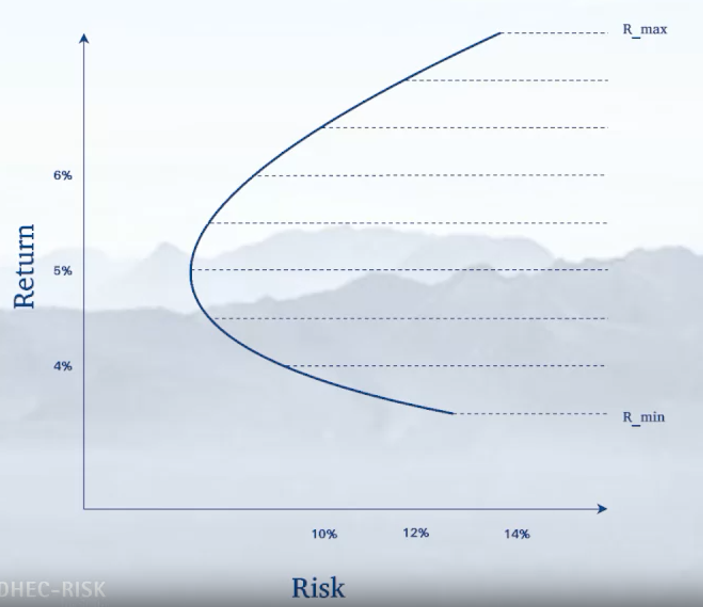

In order to find the efficient frontier recall that the portfolio on the efficient frontier is the one with the minimum volatility for a certain level of return.

Quadratic form

$$ Minimize: \frac{1}{2} \bold{w^T} \sum \bold{w} $$

Subject to

$$ \bold{w^T R} = \bold{r_0} $$
$$ \bold{w^T 1} = \bold{1} $$
$$ \bold{w} \geq \bold{0} $$

(1) The return must be at a certain level $r_0$, (2) The weights all add up to one, (3) We want all the weights to be greater than zero (no shorting).

##### Lab Session - Efficient Frontier Part II

Let's start by loading the returns and generating the expected returns vector and the covariance matrix

In [40]:
%load_ext autoreload
%autoreload 2

ind = erk.get_ind_returns()
er = erk.annualize_rets(ind['1996':'2000'], 12)
cov = ind['1996':'2000'].cov()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**What's a portfolio?** 

A portfolio corresponds to simply an allocation of capital. The weights are basically what determines how much money I put in each asset.

We want to see for every possible portfolio which represents a possible allocation of weights, where do we end up on that risk-return map.

As a first exercise, let's assume we have some weights, and let's try and compute the returns and volatility of a portfolio, given a set of weights, returns, and a covariance matrix.

The returns and volatilities are easy, so let's add this to our toolkit

In [3]:
def portfolio_return(weights, returns):
    '''
    Weights -> Returns 
    '''

    return weights.T @ returns

def portfolio_vol(weights, covmat):
    '''
    Weights -> Vol
    '''

    return (weights.T @ covmat @ weights) ** (1/2)

In [4]:
l = ['Food', 'Beer', 'Smoke', 'Coal']

er[l]

Food     0.116799
Beer     0.141126
Smoke    0.107830
Coal     0.414689
dtype: float64

In [5]:
cov.loc[l, l]

Food      Beer     Smoke      Coal
Food   0.002609  0.002379  0.002061  0.000027
Beer   0.002379  0.005264  0.001359  0.001728
Smoke  0.002061  0.001359  0.008349 -0.000733
Coal   0.000027  0.001728 -0.000733  0.018641

In [9]:
weights = np.repeat(1/4, 4)
erk.portfolio_return(weights, er[l])

0.19511097196038385

In [10]:
erk.portfolio_vol(weights, cov.loc[l, l])

0.05505919577643704

**2 Asset Frontier**

In the case of 2 assets, the problem is somewhat simplified, since the weight of the second asset is 1-the weight of the first asset.

Let's write a function that draws the efficient frontier for a simple 2 asset case.

Start by generating a sequence of weights in a list of tuples. Python makes it easy to generate a list by using something called a list comprehension ... which you can think of as an efficient way to generate a list of values instead of writing a for loop.

In [11]:
np.linspace(0, 1, 20)

array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
       0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
       0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
       0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ])

In [15]:
l = ['Games', 'Fin']

# We select a number of points we want to plot 
n_points = 20

# We define the weights for each asset
weights = [np.array([w, 1 - w]) for w in np.linspace(0, 1, n_points)]

weights

[array([0., 1.]),
 array([0.05263158, 0.94736842]),
 array([0.10526316, 0.89473684]),
 array([0.15789474, 0.84210526]),
 array([0.21052632, 0.78947368]),
 array([0.26315789, 0.73684211]),
 array([0.31578947, 0.68421053]),
 array([0.36842105, 0.63157895]),
 array([0.42105263, 0.57894737]),
 array([0.47368421, 0.52631579]),
 array([0.52631579, 0.47368421]),
 array([0.57894737, 0.42105263]),
 array([0.63157895, 0.36842105]),
 array([0.68421053, 0.31578947]),
 array([0.73684211, 0.26315789]),
 array([0.78947368, 0.21052632]),
 array([0.84210526, 0.15789474]),
 array([0.89473684, 0.10526316]),
 array([0.94736842, 0.05263158]),
 array([1., 0.])]

<AxesSubplot:xlabel='Vol', ylabel='R'>

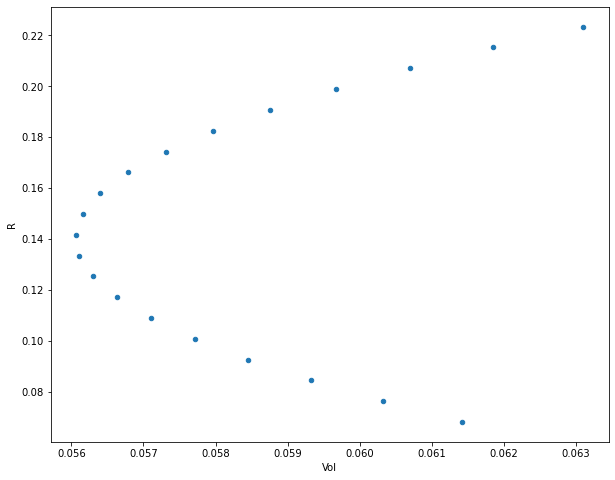

In [20]:
rets = [erk.portfolio_return(w, er[l]) for w in weights]
vols = [erk.portfolio_vol(w, cov.loc[l, l]) for w in weights]

ef = pd.DataFrame({'R': rets, 'Vol': vols})
ef.plot.scatter(x = 'Vol', y = 'R', figsize = (10,8))

<AxesSubplot:xlabel='Volatility'>

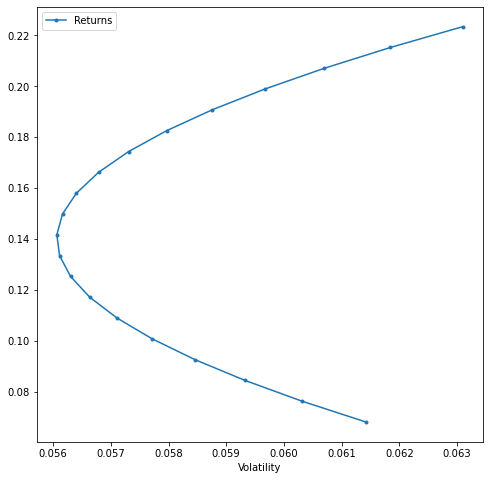

In [36]:
erk.plot_ef2(20, er[l], cov.loc[l, l])

<AxesSubplot:xlabel='Volatility'>

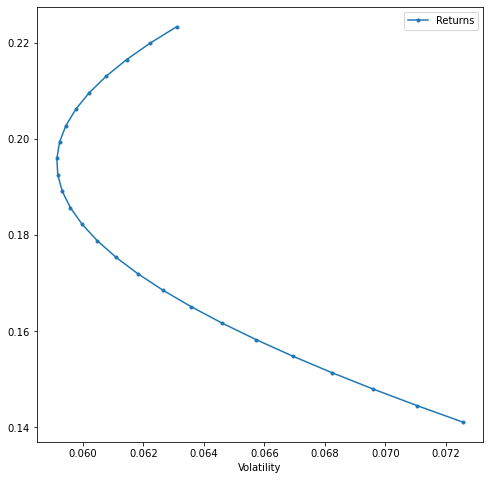

In [39]:
l = ['Fin', 'Beer']
erk.plot_ef2(25, er[l], cov.loc[l, l], style = '.-')

##### Lab Session - Applying Quadprog to Draw the Efficient Frontier Part III

In [2]:
%load_ext autoreload
%autoreload 2

ind = erk.get_ind_returns()
er = erk.annualize_rets(ind['1996':'2000'], 12)
cov = ind['1996':'2000'].cov()

In order to plot the frontier for portfolios with more than 2 assets, we need to find the weights of the portfolio on the efficient frontier.

We start by creating the same sort of function that we already created for the 2 asset case:

```python

def plot_ef(n_points, er, cov):
    """
    Plots the multi-asset efficient frontier
    """
    weights = ???? # we need to implement: optimal_weights(n_points, er, cov)
    rets = [portfolio_return(w, er) for w in weights]
    vols = [portfolio_vol(w, cov) for w in weights]
    ef = pd.DataFrame({
        "Returns": rets, 
        "Volatility": vols
    })
    return ef.plot.line(x="Volatility", y="Returns", style='.-')
```

In order to find the optimal weights, we need a function that will minimize the volatility for a given level of return.

In [43]:
from scipy.optimize import minimize

```python

def minimize_vol(target_return, er, cov):
    """
    Returns the optimal weights that achieve the target return
    given a set of expected returns and a covariance matrix
    """
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    return_is_target = {'type': 'eq',
                        'args': (er,),
                        'fun': lambda weights, er: target_return - erk.portfolio_return(weights,er)
    }
    weights = minimize(erk.portfolio_vol, init_guess,
                       args=(cov,), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,return_is_target),
                       bounds=bounds)
    return weights.x
```

Let's use this to recreate the result we got from frontier for the 2-Asset optimization between "Games" and "Fin". Let's plot that efficient frontier as we did last time:

<AxesSubplot:xlabel='Volatility'>

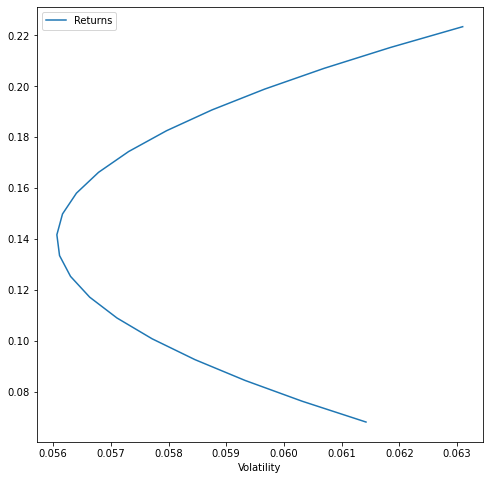

In [113]:
l = ['Games', 'Fin']
erk.plot_ef2(20, er[l], cov.loc[l, l])

In [3]:
def minimize_vol(target_return, er, cov):
    '''
    target_ret -> Weight vector (W)
    '''
    # Extract the number of assets in our data.
    n = er.shape[0]
    # Sets an initializer for the weights, i.e., we set the weights to be equally distributed.
    init_guess = np.repeat(1 / n, n)
    # Sets the bounds for each weight to be between 0.0 and 1.0
    bounds = ((0.0, 1.0),) * n
    # Defines some parameters to input in the minimizer function.
    return_is_target = {
        'type': 'eq',
        'args': (er,),
        # Function to be optimized: target_return - portfolio_return expected to be 0.
        'fun': lambda weights, er: target_return - erk.portfolio_return(weights, er)
    }
    weights_sum_to_1 = {
        'type':'eq',
        # Function to be optimized: sum of all the weights should be equal to 1.
        'fun': lambda weights: np.sum(weights) - 1 

    }

    # Apply the minimize function from scipy.optimize and passing the parameters we previously
    # defined and the necessary arguments of the function to work.
    results = minimize(erk.portfolio_vol, init_guess, args = (cov,), method = 'SLSQP',\
        options = {'disp': False}, constraints = (return_is_target, weights_sum_to_1), \
            bounds = bounds)

    return results.x

The Efficient Frontier for the protfolio that has a target return of 0.15 is approx 0.056, so let's see if our optimizer is able to locate it.

In [5]:
l = ['Games', 'Fin']
weights_15 = erk.minimize_vol(0.15, er[l], cov.loc[l,l])
vol_15 = erk.portfolio_vol(weights_15, cov.loc[l,l])
print(vol_15,'\n')
print(weights_15)

0.05616366940670658 

[0.47287631 0.52712369]


Perfect!

Now that we can find the weights to minimize the vol given a target return, we can plot the efficient frontier by dividing up the range from the highest to the lowest possible return into a grid, and finding the portfolio that targets the minimum volatility given a particular targeted rate of return.

Add these:

In [6]:
def optimal_weights(n_points, er, cov):
    '''
    -> List of weights to run the optimizer on to minimize the vol
    '''

    # Calculating the range of returns and discretizing it by n_points
    target_rs = np.linspace(er.min(), er.max(), n_points)
    # Looping and finding the optimal weights for each target return in target_rs
    weights = [minimize_vol(target_return, er, cov) for target_return in target_rs]

    return weights

def plot_ef(n_points, er, cov, figsize = (8,8), style = '-'):
    '''
    Plots the multi-asset efficient frontier
    '''

    # Computing the optimal weights for n_points and the er data.
    weights = optimal_weights(n_points, er, cov)
    # Computing the return for each weight set
    rets = [erk.portfolio_return(w, er) for w in weights]
    # Computing the volatility associated to each set of weights
    vols = [erk.portfolio_vol(w, cov) for w in weights]

    # Grouping all the information on a pandas DataFrame
    ef = pd.DataFrame({
        'Returns': rets,
        'Volatility': vols
    })

    return ef.plot.line(x = 'Volatility', y = 'Returns', style = style, figsize = figsize)

<AxesSubplot:xlabel='Volatility'>

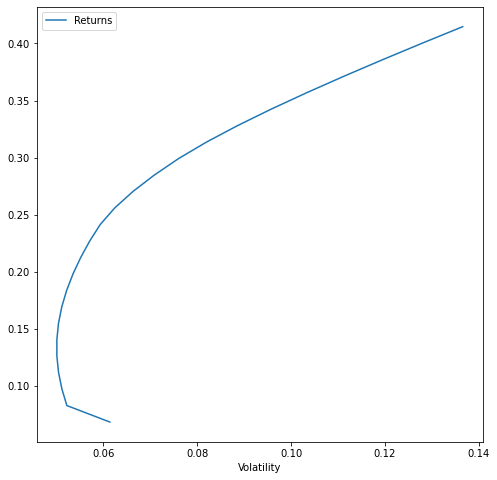

In [7]:
l = ['Games', 'Fin', 'Smoke', 'Coal']
plot_ef(25, er[l], cov.loc[l, l])

#### **Section 4 - Implementing Markowitz**

##### Fund Separation Theorem and the Capital Market Line

The efficient frontier dramatically changes shape when a risk-free asset is introduced

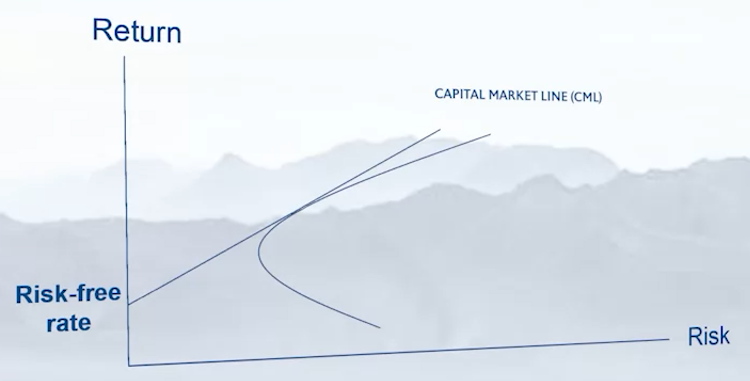

When there're only risky assets, then we get the usual shape of the Markowitz efficient frontier which is the upper side of the envelope of all feasible portfolios. When we introduce a risk-free asset, we have more feasible portfolios, in particular any portfolio that lies on a straight line that goes from the risk-free asset to any risky portfolio is also a feasible portfolio. 

The best we can do is to increase that slope of that line all the way until there's still one intersection point. That's what we call the tangency portfolio. The straight line is known as the Capital Market Line (CML), and the name we give to that portfolio is the Maximun Sharpe Ratio Portfolio (MRS).

What's so speacial about MSR is that contains no exposure to unrewarded risks.

The tangency portfolio is the portfolio that maximizes the sharpe ratio

$$ SR_p = \frac{\mu_p - r_f}{\sigma_p} = \frac{\sum_{i=1}^{N} w_i\mu_i - r_f}{\sqrt{\sum_{i,j=1}^N w_i w_j \sigma_i \sigma_j \rho_{ij}}} $$

In the presence of a risk-free asset the efficient frontier becomes a straight line (the capital market line). All investors should hold a combination of the risk-free asset and the portfolio that maximizes the reward-per-risk ratio.

**What is the max Sharpe ratio in case all securities have the same expected returns?**

The Global Minimum Variance portfolio is also Maximum Sharpe Ratio when all expected return are equal. Indeed in these conditions, portfolio weights do no longer impact the numerator of the Sharpe ratio, so maximizing the Sharpe ratio is equivalent to minimizing portfolio volatility

##### Lab Session - Locating the Max Sharpe Ratio Portfolio

We've already seen that given a set of expected returns and a covariance matrix, we can plot the efficient frontier. In this section, we'll extend the code to locate the point on the efficient frontier that we are most interested in, which is the tangency portfolio or the Max Sharpe Ratio portfolio.

Let's start by the usual imports, and load in the data.

In [19]:
%load_ext autoreload
%autoreload 2

ind = erk.get_ind_returns()
er = erk.annualize_rets(ind['1996':'2000'], 12)
cov = ind['1996':'2000'].cov()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We already know how to identify points on the curve if we are given a target rate of return. Instead of minimizing the vol based on a target return, we want to find that one point on the curve that maximizes the Sharpe Ratio, given the risk free rate.

In [9]:
def msr(riskfree_rate, er, cov):
    '''
    Returns the weights of the portfolio that gives you the maximum sharpe ratio
    given the riskfree rate and expected returns and a covariance matrix
    '''

    n = er.shape[0]
    init_guess = np.repeat(1 / n, n)
    bounds = ((0.0, 1.0),) * n
    
    weights_sum_to_1 = {
        'type':'eq',
        'fun': lambda weights: np.sum(weights) - 1 

    }

    def neg_sharpe_ratio(weights, riskfree_rate, er, cov):
        '''
        Returns the negative of the sharpe ratio, given weights
        '''

        r = erk.portfolio_return(weights, er)
        vol = erk.portfolio_vol(weights, cov)
        return -(r - riskfree_rate) / vol

    results = minimize(neg_sharpe_ratio, init_guess, args = (riskfree_rate, er, cov,), method = 'SLSQP',\
        options = {'disp': False}, constraints = (weights_sum_to_1), \
            bounds = bounds)

    return results.x

Let's guess where the point might be:

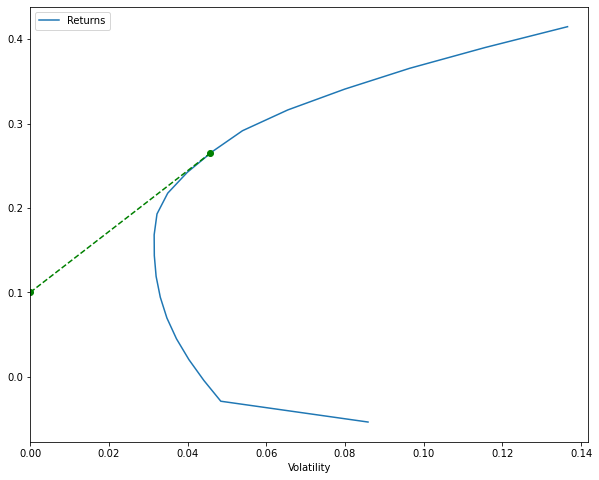

In [14]:
ax = erk.plot_ef(20, er, cov, figsize = (10, 8))
ax.set_xlim(left = 0)

rf = 0.1
w_msr = msr(rf, er, cov)
r_msr = erk.portfolio_return(w_msr, er)
vol_msr = erk.portfolio_vol(w_msr, cov)

# Add CML
cml_x = [0, vol_msr]
cml_y = [rf, r_msr]

ax.plot(cml_x, cml_y, color = 'green', marker = 'o', linestyle = 'dashed')

In [18]:
r_msr, vol_msr

(0.26473948279345444, 0.04571973228689918)

<AxesSubplot:xlabel='Volatility'>

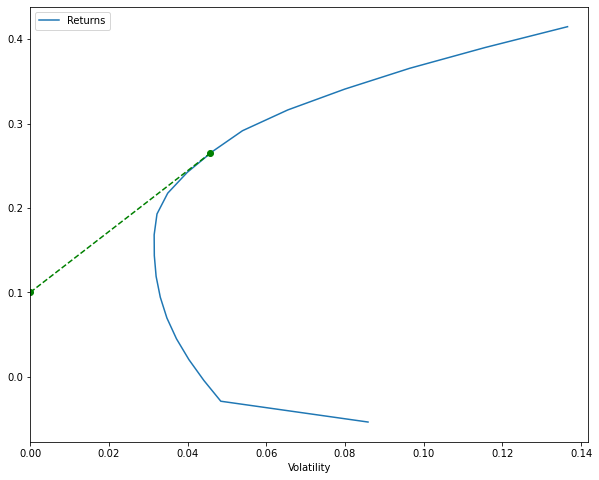

In [16]:
erk.plot_ef(20, er, cov, figsize = (10, 8), show_cml = True, riskfree_rate = 0.1)

##### Lack of robustness of Markowitz analysis

Estimation error is the key challenge in portfolio optimization

Misestimated parameters $\to$ Misspecified portfolio.

Optimizers tend to act as error maximizing machines. An optimization process, typically, the asset that gets the largest allocation is typically not the asset that is most attractive for the investor, but the asset that suffers from the largest amount of estimation risk.

Various methodologies exist for improving estimates for expected returns and covariance parameters. However some uncertainty always remains which are particularly large for expected returns.  

Expected return estimates are much harder to obtain with a good degree of accuracy compared to variance-covariance matrix estimates. Since expected returns are very noisy and not reliable, in practice, we may want to focus on the only portfolio on the efficient frontier for which no expected return parameter is needed, that portfolio is known as the Global Minimum Variance portfolio (GMV).

The GMV is the portfolio that is least sensitive to errors in parameter estimates. Since it requires no expected return estimates, it is only sensitive to errors in risk parameter estimates. 

Markowitz analysis is hardly used in practice since it tends to yield unreasonable corner solutions. This is because of the presence of parameter estimates.

##### Lab Session - Plotting EW and GMV on the Efficient Frontier

In [20]:
%load_ext autoreload
%autoreload 2

ind = erk.get_ind_returns()
er = erk.annualize_rets(ind['1996':'2000'], 12)
cov = ind['1996':'2000'].cov()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
l = ['Food', 'Steel']
erk.msr(0.1, er[l], cov.loc[l, l])

array([0.75040362, 0.24959638])

In [25]:
er[l]

Food     0.116799
Steel    0.115809
dtype: float64

In [26]:
erk.msr(0.1, np.array([.11, .12]), cov.loc[l, l])

array([0.57930354, 0.42069646])

Even a small change in the expected returns ends up causing dramatic change in weights

In [27]:
erk.msr(0.1, np.array([.10, .13]), cov.loc[l, l])

array([5.55111512e-17, 1.00000000e+00])

<AxesSubplot:xlabel='Volatility'>

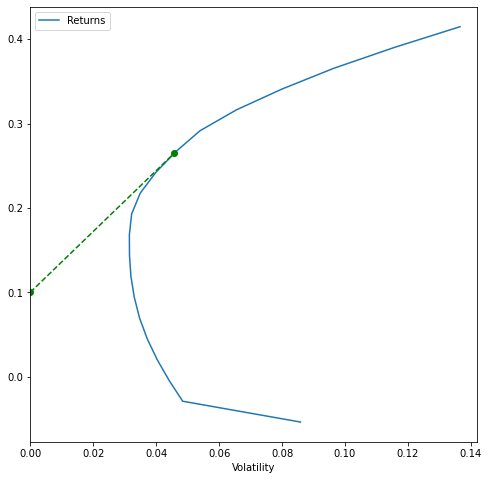

In [28]:
erk.plot_ef(20, er, cov, show_cml=True, riskfree_rate=.1)

<AxesSubplot:xlabel='Volatility'>

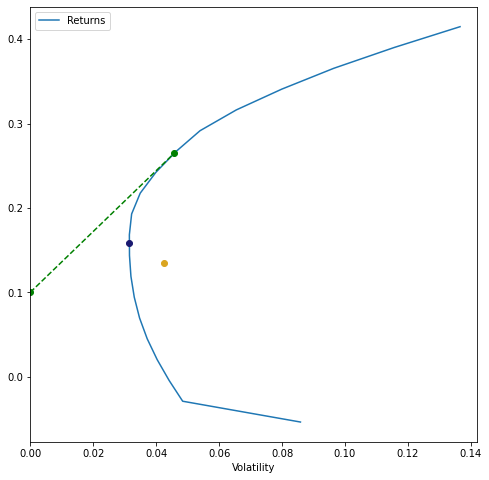

In [31]:
erk.plot_ef(20, er, cov, show_cml=True, riskfree_rate=.1, show_ew = True, show_gmv = True)

#### **Section 5**

##### Limits of Diversification

**Benefits of diversification**

* Eliminates unrewarded idiosyncratic risks

Diversification will fail you when you need it the most. Almost by definition one cannoit diversify away systematic risk (a risk factor that impacts all the assets simultaneously). You cannot diversify away systematic risk, you can only diversify with specific risk or idiosyncratic risk. 

Diversification allows investors to reduce specific risk within their portfolios, which is how they can achieve a high reward per unit of risk. The main benefit of diversification is to deliver the highest reward per unit of risk across market conditions.  

**Hedging** (i.e., avoiding risk taking) is the only effective way to obtain downside protection. The problem with hedging is that investors give up on the upside at the same time as they give up on the downside

**Benefits of insurance**

Get downside protection while allowing for upside potential. The best of both worlds? Insurance: Dynamic hedging. One way to think about it is when you're facing the dilemma in terms of how much should they put at risk and bring to the market in terms of eggs, how much do I allocate to performance seeking assets in other words, and how much should I keep safe home. 

* If you allocate very little to the performance seeking portfolio, in most market conditions and across many scenarios, you're not going to enjoy the upside potential that you need, so that's not good. 
* On the other hand, if you allocate lots to risky assets in those few scenarios when things go wrong, you all going to be wasted. You're going to go bankrupt.

It turns out that the best way to deal with this situation is actually to implement dynamic hedging.

Adjust risk-taking as a function of the margin for error, and when the margin for error dissapears we should slow down, while the margin for error is big we should speed up in terms of risk-taking.

##### Lab Session - Limits of Diversification Part 1

Why doesnt diversification help you in market crashes?

One reason is that correlations across assets increases as the market drops. Let's see if we can see this in the data.

Let's load up the industry data that we've used in the past.

In [3]:
ind_return = erk.get_ind_returns()

**Implementing a Cap-Weighted Portfolio**

Most market indices are constructed by taking a set of assets and weighting them by their market equity aka market capitalization.

Let's construct a market cap weighted index from our 30 industry portfolios.

For each of these industries, we also have data on the number of stocks in each industry as well as the average market cap in each industry. Thus, we can multiply the average market cap by the number of companies to get the total market capitalization of each industry. We can then weight each industry portfolio proportional to the market capitalization of that industry.

Let's load the industry size and average number of firms:

```python
def get_ind_nfirms():
    """
    Load and format the Ken French 30 Industry Portfolios Average number of Firms
    """
    ind = pd.read_csv("data/ind30_m_nfirms.csv", header=0, index_col=0)
    ind.index = pd.to_datetime(ind.index, format="%Y%m").to_period('M')
    ind.columns = ind.columns.str.strip()
    return ind

def get_ind_size():
    """
    Load and format the Ken French 30 Industry Portfolios Average size (market cap)
    """
    ind = pd.read_csv("data/ind30_m_size.csv", header=0, index_col=0)
    ind.index = pd.to_datetime(ind.index, format="%Y%m").to_period('M')
    ind.columns = ind.columns.str.strip()
    return ind
```

In [12]:
%load_ext autoreload
%autoreload 2

In [4]:
ind_return = erk.get_ind_returns()
ind_size = erk.get_ind_size()
ind_nfirms = erk.get_ind_nfirms()

In [5]:
ind_return.shape

(1110, 30)

In [18]:
ind_size.shape

(1110, 30)

In [19]:
ind_nfirms.shape

(1110, 30)

In [20]:
ind_nfirms.head()

Food  Beer  Smoke  Games  Books  Hshld  Clths  Hlth  Chems  Txtls  \
1926-07    43     3     16      7      2      8     12     7     17     13   
1926-08    43     3     16      7      2      8     12     7     17     13   
1926-09    43     3     16      7      2      8     12     7     17     13   
1926-10    43     3     16      7      2      8     12     7     17     13   
1926-11    43     3     16      7      2      8     12     7     17     13   

         ...  Telcm  Servs  BusEq  Paper  Trans  Whlsl  Rtail  Meals  Fin  \
1926-07  ...      5      3      7      6     74      2     33      6   12   
1926-08  ...      5      3      7      6     74      2     33      6   12   
1926-09  ...      5      3      7      6     74      2     33      6   12   
1926-10  ...      5      3      7      6     74      2     33      6   12   
1926-11  ...      5      3      7      6     74      2     33      6   12   

         Other  
1926-07      4  
1926-08      4  
1926-09      4  
1926-10      4  
1926-11      4  

[5 rows x 30 columns]

In [22]:
ind_size.head()

Food  Beer  Smoke  Games  Books  Hshld  Clths   Hlth  Chems  Txtls  \
1926-07  35.98  7.12  59.72  26.41  12.02  22.27  18.36  25.52  57.59   6.18   
1926-08  36.10  6.75  60.47  27.17  13.33  22.13  19.83  25.80  62.13   6.20   
1926-09  37.00  8.58  64.03  27.30  14.67  21.18  19.29  26.73  65.53   6.71   
1926-10  37.14  8.92  64.42  28.76  14.42  21.23  19.03  26.87  68.47   6.82   
1926-11  35.88  8.62  65.08  27.38  15.79  20.14  19.03  26.54  65.06   6.84   

         ...   Telcm  Servs  BusEq  Paper  Trans  Whlsl  Rtail  Meals    Fin  \
1926-07  ...  350.36  13.60  56.70  35.35  66.91   1.19  46.65  10.82  18.83   
1926-08  ...  353.27  14.75  57.74  37.86  67.99   0.90  46.57  11.00  18.88   
1926-09  ...  360.96  15.05  59.61  36.82  71.02   0.95  46.11  10.94  19.67   
1926-10  ...  364.16  15.30  59.52  34.77  70.83   0.88  46.15  10.80  19.36   
1926-11  ...  363.74  14.89  58.74  32.80  68.75   0.74  45.03  10.33  18.35   

         Other  
1926-07  24.25  
1926-08  25.51  
1926-09  27.21  
1926-10  26.16  
1926-11  23.94  

[5 rows x 30 columns]

In [5]:
ind_mktcap = ind_nfirms * ind_size
ind_mktcap.head()

Food   Beer    Smoke   Games  Books   Hshld   Clths    Hlth  \
1926-07  1547.14  21.36   955.52  184.87  24.04  178.16  220.32  178.64   
1926-08  1552.30  20.25   967.52  190.19  26.66  177.04  237.96  180.60   
1926-09  1591.00  25.74  1024.48  191.10  29.34  169.44  231.48  187.11   
1926-10  1597.02  26.76  1030.72  201.32  28.84  169.84  228.36  188.09   
1926-11  1542.84  25.86  1041.28  191.66  31.58  161.12  228.36  185.78   

           Chems  Txtls  ...    Telcm  Servs   BusEq   Paper    Trans  Whlsl  \
1926-07   979.03  80.34  ...  1751.80  40.80  396.90  212.10  4951.34   2.38   
1926-08  1056.21  80.60  ...  1766.35  44.25  404.18  227.16  5031.26   1.80   
1926-09  1114.01  87.23  ...  1804.80  45.15  417.27  220.92  5255.48   1.90   
1926-10  1163.99  88.66  ...  1820.80  45.90  416.64  208.62  5241.42   1.76   
1926-11  1106.02  88.92  ...  1818.70  44.67  411.18  196.80  5087.50   1.48   

           Rtail  Meals     Fin   Other  
1926-07  1539.45  64.92  225.96   97.00  
1926-08  1536.81  66.00  226.56  102.04  
1926-09  1521.63  65.64  236.04  108.84  
1926-10  1522.95  64.80  232.32  104.64  
1926-11  1485.99  61.98  220.20   95.76  

[5 rows x 30 columns]

In [6]:
total_mktcap = ind_mktcap.sum(axis = 'columns')

<Axes: >

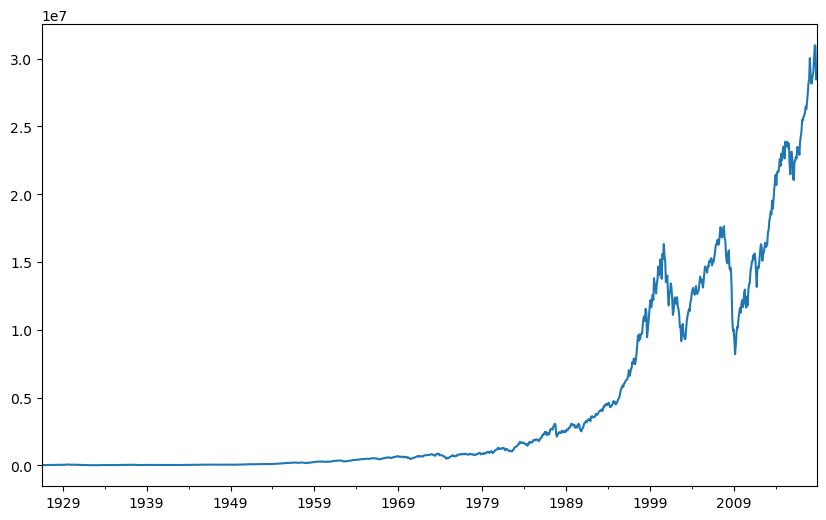

In [28]:
total_mktcap.plot(figsize = (10, 6))

In [7]:
ind_capweight = ind_mktcap.divide(total_mktcap, axis = 'rows')

In [37]:
ind_capweight.head()

Food      Beer     Smoke     Games     Books     Hshld     Clths  \
1926-07  0.058037  0.000801  0.035844  0.006935  0.000902  0.006683  0.008265   
1926-08  0.056578  0.000738  0.035264  0.006932  0.000972  0.006453  0.008673   
1926-09  0.056699  0.000917  0.036510  0.006810  0.001046  0.006038  0.008249   
1926-10  0.056920  0.000954  0.036736  0.007175  0.001028  0.006053  0.008139   
1926-11  0.056725  0.000951  0.038285  0.007047  0.001161  0.005924  0.008396   

             Hlth     Chems     Txtls  ...     Telcm     Servs     BusEq  \
1926-07  0.006701  0.036726  0.003014  ...  0.065714  0.001531  0.014889   
1926-08  0.006583  0.038497  0.002938  ...  0.064380  0.001613  0.014732   
1926-09  0.006668  0.039700  0.003109  ...  0.064318  0.001609  0.014870   
1926-10  0.006704  0.041486  0.003160  ...  0.064896  0.001636  0.014850   
1926-11  0.006831  0.040665  0.003269  ...  0.066868  0.001642  0.015118   

            Paper     Trans     Whlsl     Rtail     Meals       Fin     Other  
1926-07  0.007956  0.185736  0.000089  0.057748  0.002435  0.008476  0.003639  
1926-08  0.008280  0.183379  0.000066  0.056014  0.002406  0.008258  0.003719  
1926-09  0.007873  0.187292  0.000068  0.054227  0.002339  0.008412  0.003879  
1926-10  0.007436  0.186812  0.000063  0.054280  0.002310  0.008280  0.003730  
1926-11  0.007236  0.187051  0.000054  0.054635  0.002279  0.008096  0.003521  

[5 rows x 30 columns]

<Axes: >

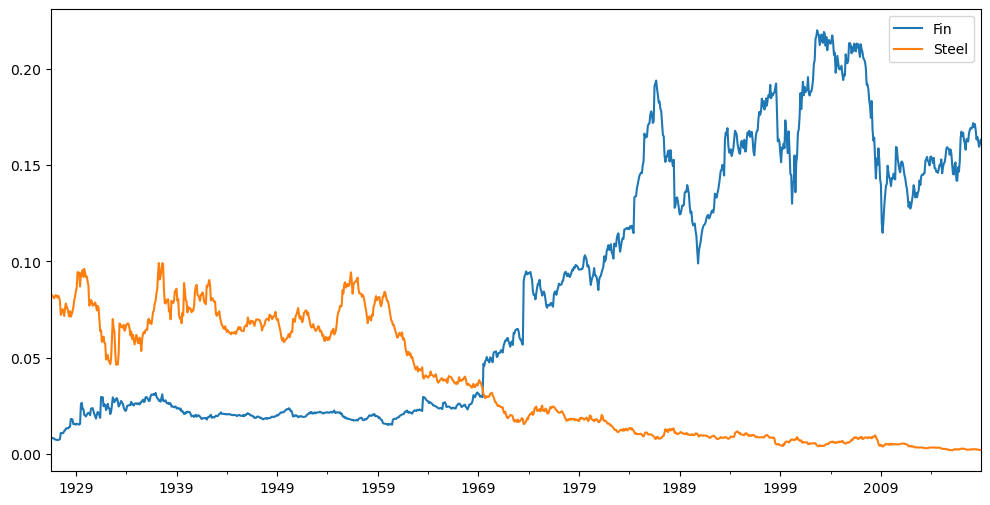

In [39]:
ind_capweight[['Fin', 'Steel']].plot(figsize = (12, 6))

<Axes: >

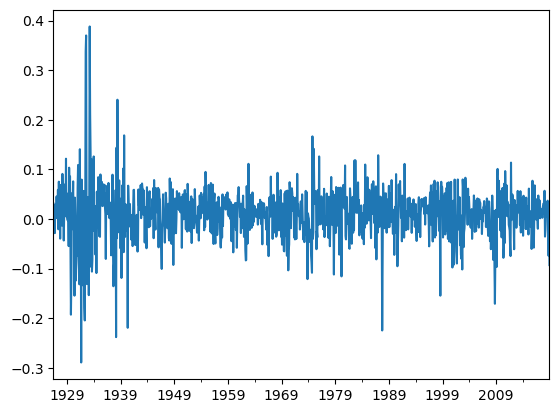

In [8]:
total_market_return = (ind_capweight * ind_return).sum(axis = 'columns')
total_market_return.plot()

<Axes: title={'center': 'Total Market CapWeighted Index 1926-2018'}>

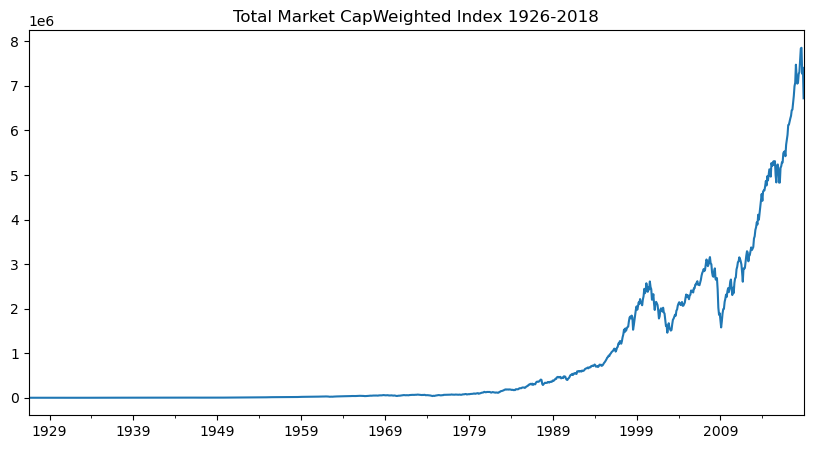

In [9]:
total_market_index = erk.drawdown(total_market_return).Wealth
total_market_index.plot(figsize = (10, 5), title = 'Total Market CapWeighted Index 1926-2018')

<Axes: >

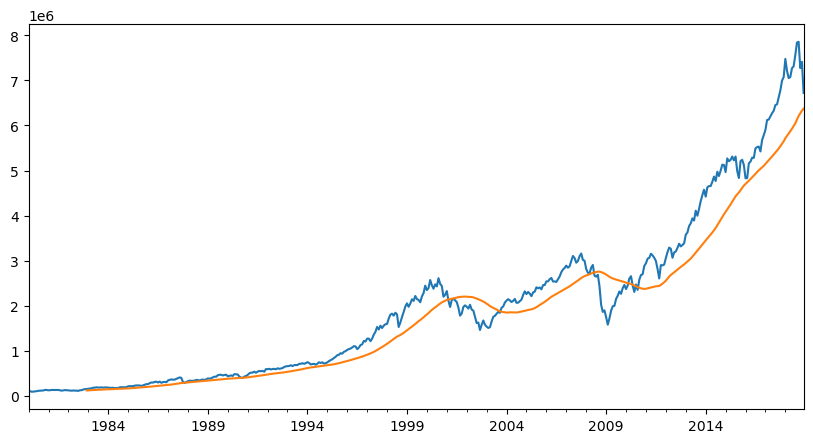

In [10]:
total_market_index['1980':].plot(figsize = (10, 5))
total_market_index['1980':].rolling(window = 36).mean().plot()

<Axes: >

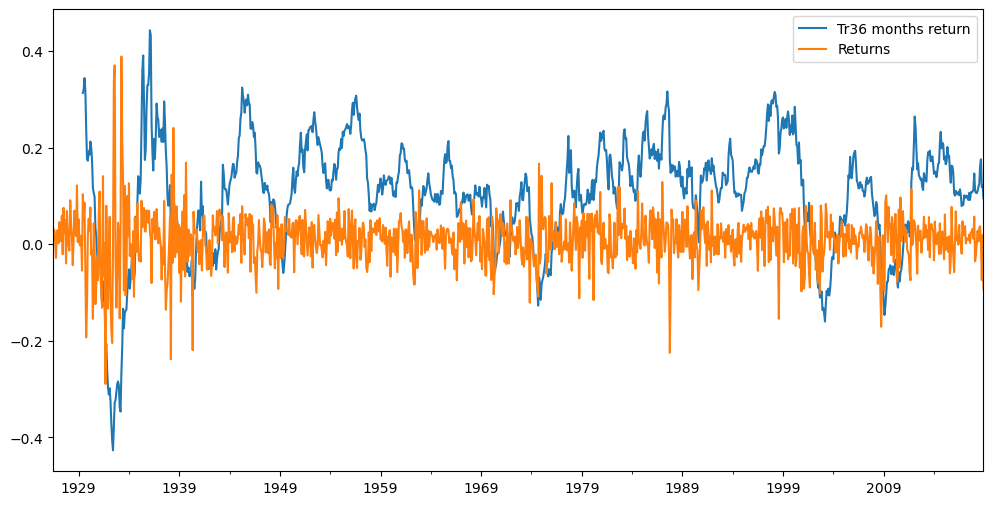

In [16]:
tmi_tr36rets = total_market_return.rolling(window = 36).aggregate(erk.annualize_rets, periods_per_year = 12)
tmi_tr36rets.plot(figsize=(12,6), label = 'Tr36 months return', legend = True)
total_market_return .plot(label = 'Returns', legend = True)